# Nichenet Analysis for young and old mice

In [80]:
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(plotrix))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(nichenetr))
suppressPackageStartupMessages(library(gridExtra))

nn_folder = "/home/ramadatta/sw/nichenet/Niklas/nichenet_models/"
ligand_target_matrix <- readRDS(paste0(nn_folder, "ligand_target_matrix_MOUSE.rds"))
lr_network <- readRDS(paste0(nn_folder, "ligand_receptor_network_MOUSE.rds"))
weighted_networks_lr <- readRDS(paste0(nn_folder, "weighted_ligand_receptor_network_MOUSE.rds"))

setwd("/home/ramadatta/Analysis/1_Schiller_Lab/for_collaborators/Janine/1_Bleomycin_ageing/")
source("/home/ramadatta/Analysis/1_Schiller_Lab/for_collaborators/Janine/1_Bleomycin_ageing/4_Scripts_Meshal/NicheNet_functions.R")


In [118]:
options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 100)

ct_order = c("Airway", "Alveolum", "MNP", "Lymphocytes", "Granulocytes", "Fibroblasts",
          "Pericytes", "SMC", "Mesothelium", "Capillary_ECs", "Vascular_ECs","Lymphatic_ECs")

ct_map = c("Airway", "Alveolum", "MNP", "Lymphocytes", "Granulocytes", "Fibroblasts",
          "Pericytes", "SMC", "Mesothelium", "Capillary_ECs", "Vascular_ECs","Lymphatic_ECs")

## Let’s set colours :)
ct_cols = c("Airway" = "#ffd000", "Alveolum" = "#663399", "MNP" = "#424cb8",
            "Lymphocytes" = "#b22222", "Granulocytes" = "#d2b48c", 
             "Fibroblasts" = "#078c46", "Pericytes" = "#87cefa", "SMC" = "#fcb1c6", "Mesothelium" = "gray",
             "Capillary_ECs" = "#9acd32",
             "Vascular_ECs" = "#cf7c00", "Lymphatic_ECs" = "#ede3b4")

## Colour Palettes
condition_colors <- c("thistle1", "mediumorchid1", "purple3", "purple4", 
                      "lightskyblue1", "lightskyblue", "dodgerblue3", "dodgerblue4")
names(condition_colors) <- c("old_nodes", "old_mid", "old_vertex", "old",
                             "young_nodes", "young_mid", "young_vertex", "young")

In [119]:
#source("/storage/groups/ml01/workspace/meshal.ansari/PhD_Scripts/scRNA_Analysis_CodeRepo/thesis_functions_R.R")

## Colour Palettes
condition_colors <- c("thistle1", "mediumorchid1", "purple3", "purple4", 
                      "lightskyblue1", "lightskyblue", "dodgerblue3", "dodgerblue4")
names(condition_colors) <- c("old_nodes", "old_mid", "old_vertex", "old",
                             "young_nodes", "young_mid", "young_vertex", "young")

order = c("Airway", "Alveolum", "MNP", "Lymphocytes", "Granulocytes", "Fibroblasts",
          "Pericytes", "SMC", "Mesothelium", "Capillary_ECs", "Vascular_ECs","Lymphatic_ECs")

get_upregulated_genes_all <- function(time, logfc = "genes_logfc_05"){
    tab = tab_genes[grep(paste0(time, "_up"), rownames(tab_genes)), "genes_logfc_05", drop = F]
    genes <- lapply(rownames(tab), function(x){strsplit(tab[x,], ",")[[1]]})
    names(genes) <- gsub("_up", "", rownames(tab))
    return(genes)
}

# Young Mice

### Access DGE results file

In [82]:
tab_genes = read.delim("1_Meshal_DGE/dge_compartment_label_young/control_vs_bleo_regulated_genes_timepoints_compartment_label_young.txt",
                       check.names = F, sep = "\t", stringsAsFactors = F, row.names = 1)
head(tab_genes[, 3, drop = F], 2)

,genes_logfc_2
,<chr>
Airway_d3_up,"Ifit3,Lgals3bp,Isg15,Rtp4,Irf7,Iigp1,Ifitm3,Ifit3b,Ifit1,Oasl2,Ifi44,H2-K1,Stat1,Ddx60,Tgtp1,Bst2,Orm1,Oas1a,Cd177,Ifi47,Xaf1,Ube2l6,Ccng1,Apol9b,Irf9,Irgm1,Retnla,H2-D1,Rnf213,Speer4c,Phlda3,Cxcl15,Ly6a"
Airway_d3_down,"Cavin2,Cdkn1c,Cep70,Gm42418,Bms1,CT010467.1,Col23a1,Tent5c,Bcl7a,Palmd,Klf15,Nasp,Tcerg1"


In [83]:
master_tab <- read.delim("/home/ramadatta/Analysis/1_Schiller_Lab/for_collaborators/Janine/1_Bleomycin_ageing/1_Meshal_DGE/dge_compartment_label_young/diffxpy_all_control_vs_bleo_timepoints_compartment_label_young.txt",
                         check.names = F, sep = "\t", stringsAsFactors = F, row.names = 1)
master_tab[c("Krt8", "Sprr1a", "Fn1"), 1:8]

,pval_Airway_d10,pval_Airway_d21,pval_Airway_d28,pval_Airway_d3,pval_Airway_d42,pval_Alveolum_d10,pval_Alveolum_d21,pval_Alveolum_d28
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Krt8,0.001860176,0.5361491,0.804179,0.709502,2.664535e-15,0.000000e+00,0,0.0002718218
Sprr1a,NA,NA,NA,NA,NA,1.865175e-14,NA,NA
Fn1,NA,NA,NA,NA,NA,NA,NA,NA


### Sanity Check file contents before Nichenet Run 

#### Establish using young mice time point day 10

In [84]:
condition = "bleo"
age = "young"
time = "d10"

avg_expr = master_tab[, grep(paste0("avgExpr_.*_", time), colnames(master_tab))]
avg_pct = master_tab[, grep(paste0("pct.bleo_.*_", time), colnames(master_tab))]
de_genes_tab = tab_genes[grep(paste0(time, "_up"), rownames(tab_genes)), "genes_logfc_05", drop = F]

In [85]:
de_genes_tab

genes_logfc_05                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [86]:
colnames(avg_expr)
colnames(avg_pct)

[1] "avgExpr_Airway_d10"        "avgExpr_Alveolum_d10"     
 [3] "avgExpr_Capillary_ECs_d10" "avgExpr_Fibroblasts_d10"  
 [5] "avgExpr_Granulocytes_d10"  "avgExpr_Lymphatic_ECs_d10"
 [7] "avgExpr_Lymphocytes_d10"   "avgExpr_MNP_d10"          
 [9] "avgExpr_Mesothelium_d10"   "avgExpr_Pericytes_d10"    
[11] "avgExpr_SMC_d10"           "avgExpr_Vascular_ECs_d10"

[1] "pct.bleo_Airway_d10"        "pct.bleo_Alveolum_d10"     
 [3] "pct.bleo_Capillary_ECs_d10" "pct.bleo_Fibroblasts_d10"  
 [5] "pct.bleo_Granulocytes_d10"  "pct.bleo_Lymphatic_ECs_d10"
 [7] "pct.bleo_Lymphocytes_d10"   "pct.bleo_MNP_d10"          
 [9] "pct.bleo_Mesothelium_d10"   "pct.bleo_Pericytes_d10"    
[11] "pct.bleo_SMC_d10"           "pct.bleo_Vascular_ECs_d10"

### Run NicheNet Pipeline for d10 fibroblasts as receiver

In [89]:
receiver_ct = "Fibroblasts_d10"
condition = "bleo"
age = "young"
path = "Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/"
## give regex as parameter as well, to remove "_d10" at the end
reg = paste0("pct\\.|", condition, "_", "|_d[[:alnum:]]+")

## Get geneset of interest from pre-created de gene list
geneset_oi = get_upregulated_genes_receiver(condition = condition, receiver_ct = receiver_ct)
ligand_act <- get_regulatory_potential(avg_pct, avg_pct, reg = reg, geneset_oi, receiver_ct = receiver_ct, 
                                       condition = condition, save = T, path = path,
                                       suffix = paste0("_", age))
head(ligand_act, 4)

[1] "Fibroblasts_d10"
[1] "Fn1,Col3a1,Lgals1,Igfbp7,Kif26b,Timp1,Serpine2,Thbs1,Ecscr,Sfrp1,Postn,Spp1,Col5a2,Col5a1,Col1a1,Col1a2,Sparc,Ppic,Ltbp2,Tnc,Fst,Fstl1,Rplp0,Acta2,Actb,Fbn1,Nrep,Ckap4,Serpina3n,Mgp,Calm1,Igf1,Mt2,Phldb2,Tubb5,Vmp1,Cd63,Tpm1,Inhba,Col12a1,Mmp14,Actn1,C1qtnf6,Ccdc80,Nrcam,Serpine1,Rack1,Slc39a14,Tmsb4x,Anxa2,Pabpc1,Eln,Gnas,P4hb,Col4a2,Lox,Runx1,Ccn4,Rps2,Sec13,Prdx5,Myl12a,Bpgm,Bmper,Arpc2,Col6a3,Id3,Iigp1,Piezo2,Prdx1,Col4a1,B2m,Mt1,Cnn3,Grem1,Ext1,Ssr2,Cspg4,Tagln2,Hnrnpab,Serpinh1,Cd44,Fmod,Cpxm1,Enc1,Ssr3,Ppia,Pxdn,Tpm4,Ccnd1,Col6a2,H3f3b,Mmp2,Angptl4,Tmem176a,Chl1,Banf1,Ncam1,Tm4sf1,Col7a1,Txn1,Col8a1,Slc25a5,Dclk1,Pls3,Rps27l,Rcan1,Hbegf,Col5a3,Cthrc1,Pfn1,Myh9,Lsp1,Cnn2,Rpl15,Car2,Hivep3,Psmd8,Loxl2,Ppp1r14b,Basp1,Isyna1,Psmd14,Fkbp1a,Tnfrsf12a,Nme1,Sec61b,Morf4l2,Tspan4,Fkbp11,Hist1h1c,Uck2,Sept9,Ldha,Cyb5r3,Dbn1,Psmb4,Ostc,Bmp1,Slco2a1,Rbm3,Maged1,Fbln2,Anxa1,Ranbp1,Tmem123,Actr3,Dut,Ran,Gjb5,Rpl7a,Cyp51,AI506816,Mgll,Fzd1,Pdgfrb,Arf1,Srpx2,Actn4,Rnf

test_ligand,auroc,aupr,aupr_corrected,pearson,rank,expressed_in,upregulated_in
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Tgfb1,0.6039391,0.2465947,0.11865826,0.2219137,1,"Lymphatic_ECs, MNP",
Fgf2,0.5789240,0.1986899,0.07075351,0.1471748,2,"Fibroblasts, Mesothelium",
Spp1,0.5842681,0.1911062,0.06316985,0.1434095,3,"Fibroblasts, MNP, Pericytes","Fibroblasts, MNP"
Vwf,0.5838947,0.1881392,0.06020285,0.1383744,4,"Capillary_ECs, Vascular_ECs",Capillary_ECs


### Plot Regulatory Potential and Dotplot (only Bleo cells, young at day 10)

[1] "number of genes of interest 354"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


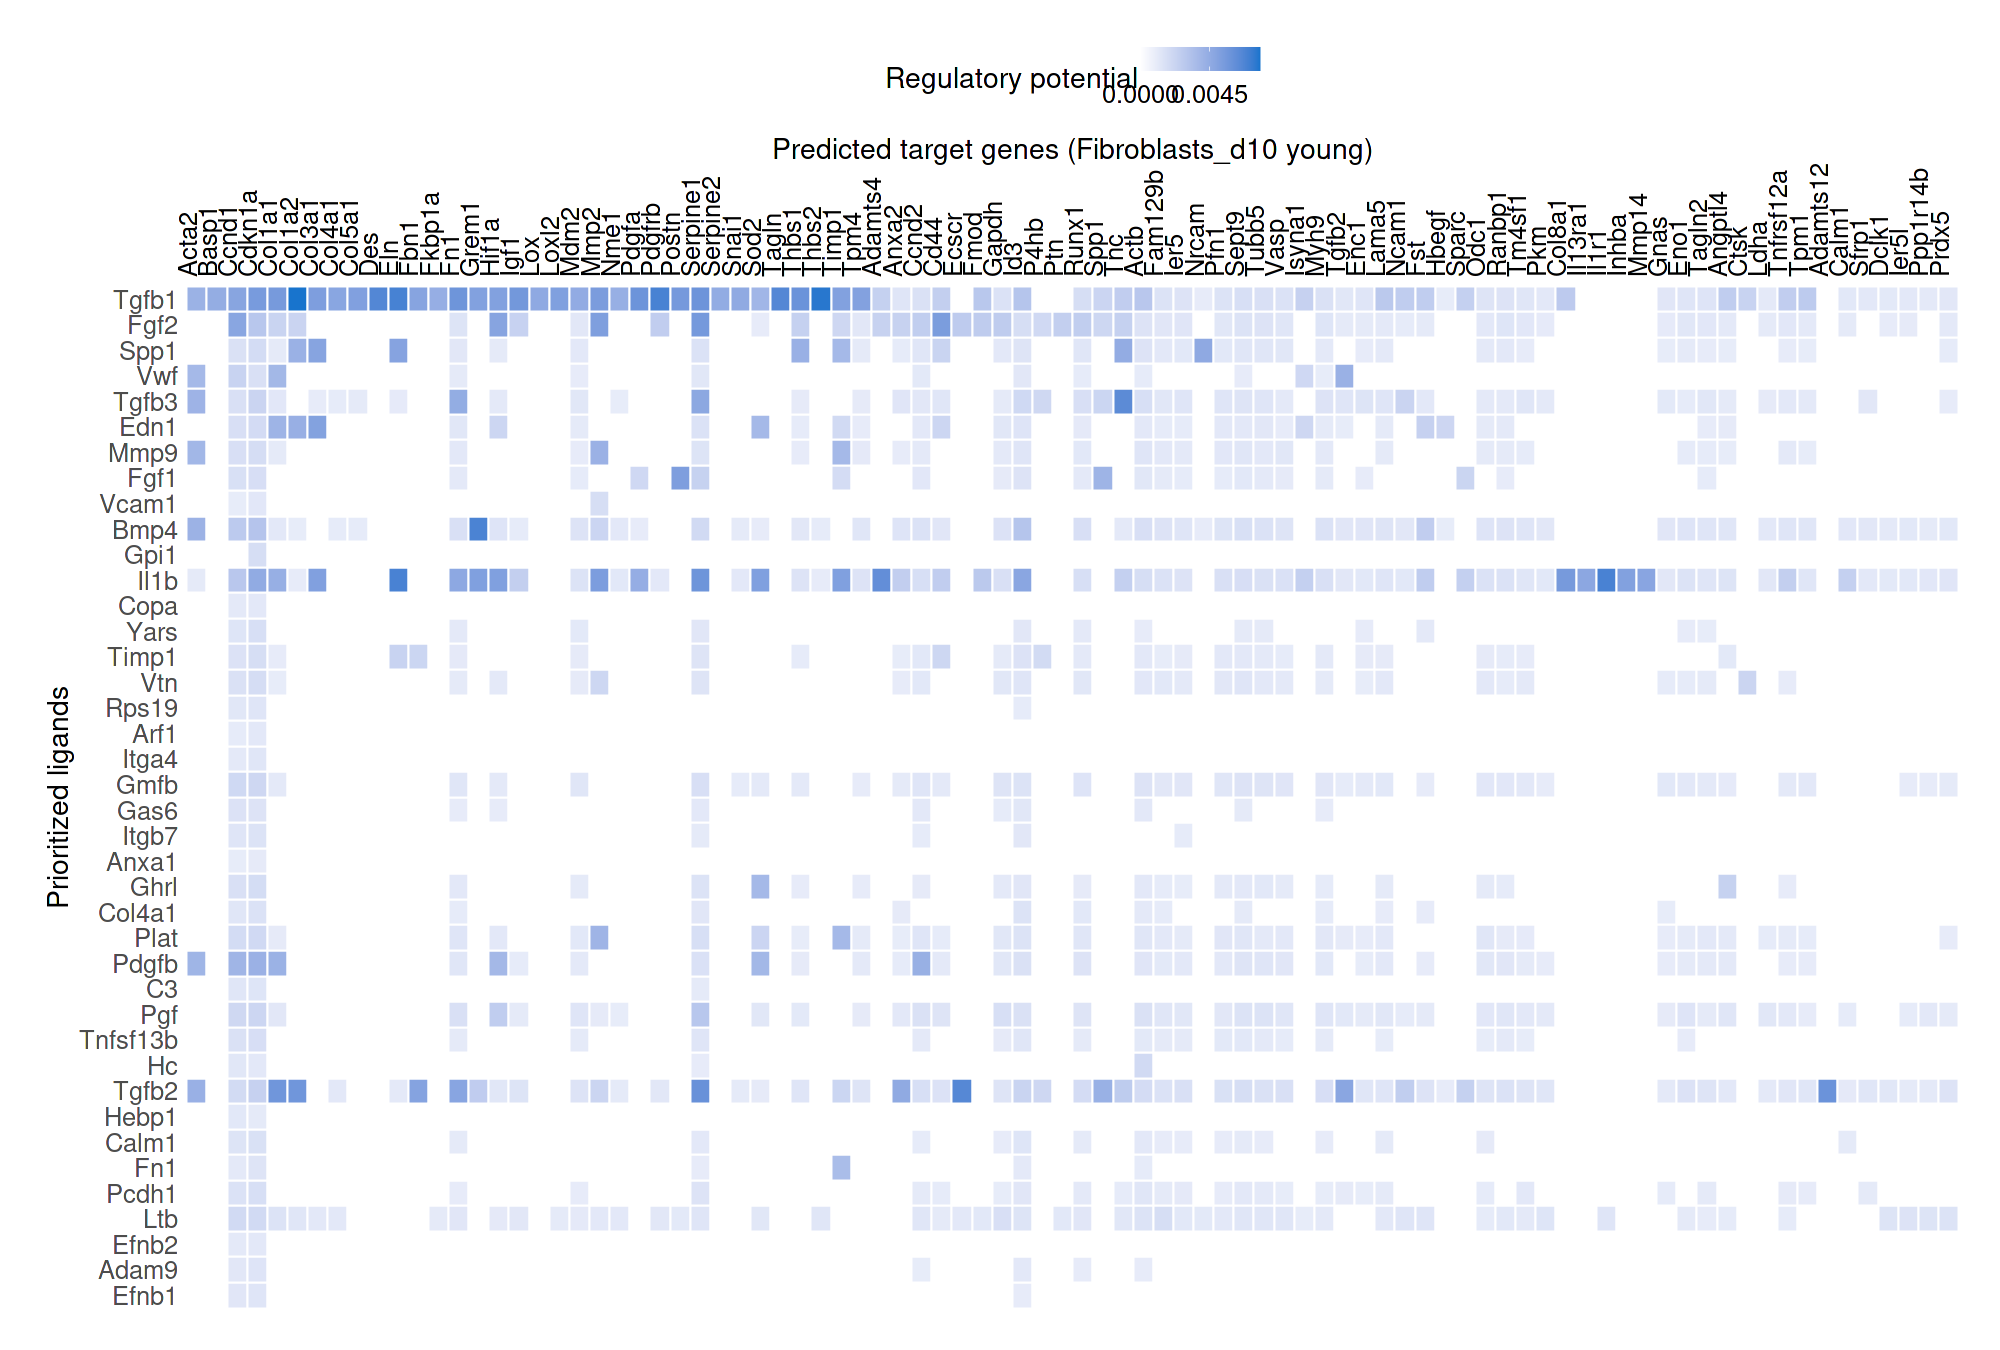

In [91]:
options(repr.plot.width = 20, repr.plot.height = 13.5, repr.plot.res = 100)
folderpath="/home/ramadatta/Analysis/1_Schiller_Lab/for_collaborators/Janine/1_Bleomycin_ageing/Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/"
p1 <- plot_ligand_targets(ligand_act, genes = geneset_oi, top = 40, condition = "young", bottom = 1,
                          receiver_ct = receiver_ct,path=folderpath
                         )
plot(p1)

Warning message:
“Removed 289 rows containing missing values (`geom_point()`).”


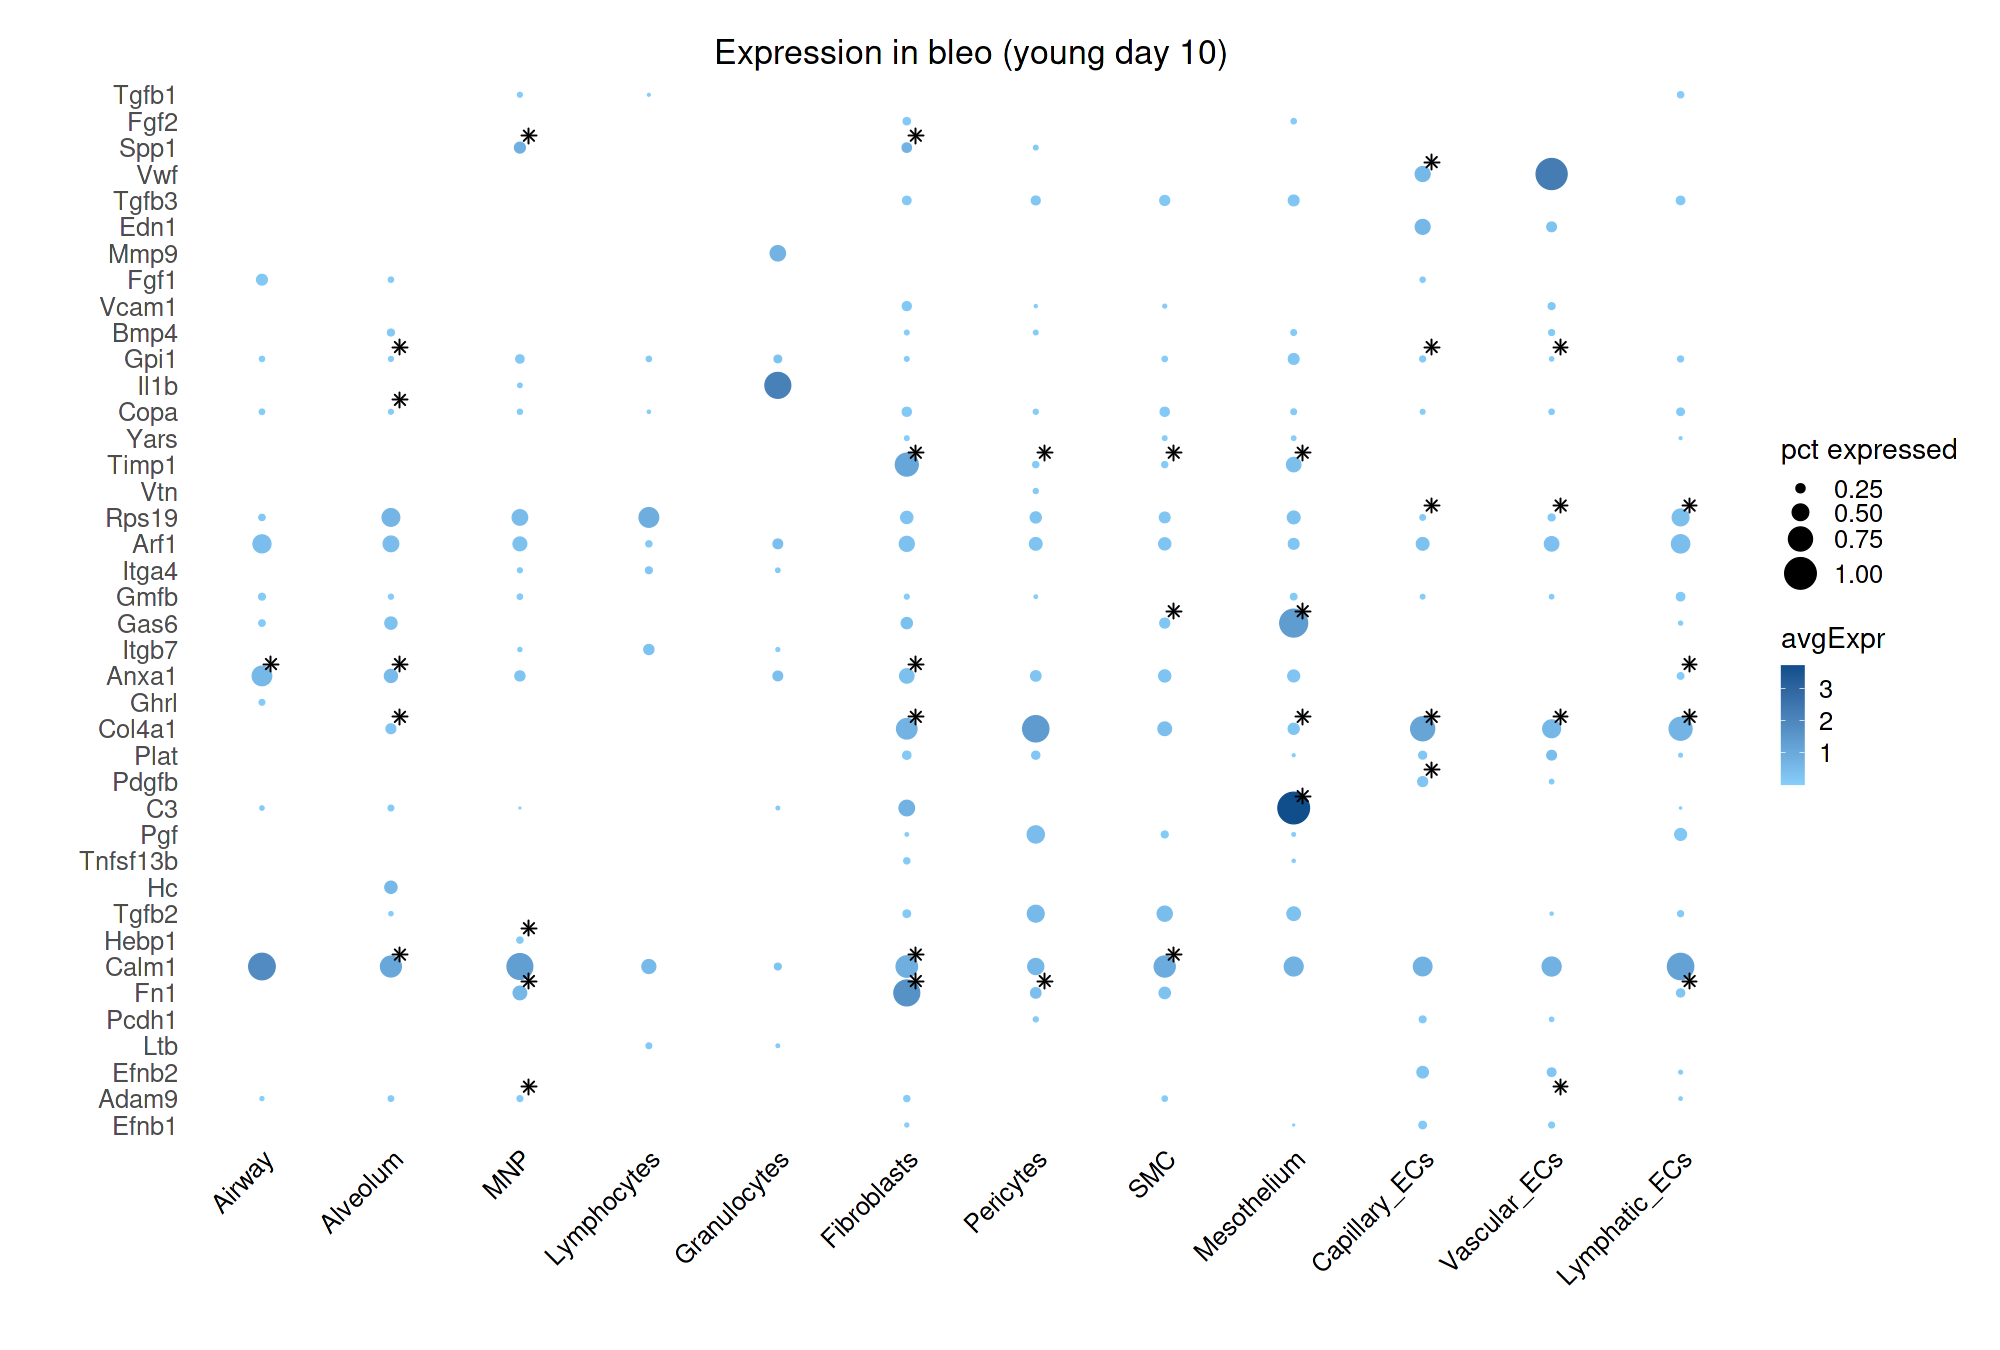

In [92]:
time = "day 10"
p2 <- ligand_dotplot(avg_pct, avg_expr, ligand_act, genes = unique(as.character(p1$data$y)), order = order, star = T,
                     title_add = paste0("(", age, " ", time, ")"), condition = condition, colour = age, col.min = -2, 
                     col.max = 2, scale = TRUE, reg = reg, dot.min = 0.1, dot.scale = 10, top = 40, top_pad = 1)
plot(p2)

### Run and save Tables and plots for all cell types as receiver
#### day 3 young

In [96]:
condition = "bleo"
age = "young"
time = "d3"
path = paste0("Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/", age, "_timeseries/")
reg = paste0("pct\\.|", condition, "_", "|_d[[:alnum:]]+")

avg_expr = master_tab[, grep(paste0("avgExpr_.*_", time), colnames(master_tab))]
avg_pct = master_tab[, grep(paste0("pct.bleo_.*_", time), colnames(master_tab))]
all_upregulated <- get_upregulated_genes_all(time)

In [97]:
str(all_upregulated)

List of 12
 $ Airway_d3       : chr [1:123] "Ifitm3" "Isg15" "Irf7" "Iigp1" ...
 $ Alveolum_d3     : chr [1:460] "Malt1" "Nme1" "Nfe2l2" "Ndufb6" ...
 $ Capillary_ECs_d3: chr [1:100] "Ackr3" "Col4a2" "Mcam" "Ly6e" ...
 $ Fibroblasts_d3  : chr [1:166] "Ifitm3" "Irf7" "Zbp1" "Iigp1" ...
 $ Granulocytes_d3 : chr [1:38] "AA467197" "Ftl1" "Clec5a" "Csf1" ...
 $ Lymphatic_ECs_d3: chr [1:136] "Ifit2" "Slc25a22" "Sh2d5" "Kctd1" ...
 $ Lymphocytes_d3  : chr [1:4] "Ifi27l2a" "Ly6a" "Nfkb2" "Vim"
 $ MNP_d3          : chr [1:206] "AA467197" "Litaf" "Ly6e" "Ly86" ...
 $ Mesothelium_d3  : chr [1:77] "Ifitm3" "Fth1" "Ifi27l2a" "Cfb" ...
 $ Pericytes_d3    : chr [1:89] "Ifitm3" "Actb" "Iigp1" "B2m" ...
 $ SMC_d3          : chr [1:106] "Ifitm3" "Rfc3" "Isg15" "Nup93" ...
 $ Vascular_ECs_d3 : chr [1:140] "Ifitm3" "Lrg1" "Ackr3" "Slco2a1" ...


In [98]:
# Created Plots/NicheNet_meta_output/young_timeseries

for(ct in order){
    receiver_ct = paste0(ct, "_", time)
    print(receiver_ct)
    
    ## Get geneset of interest from pre-created de gene list and save potential ligand tables
    geneset_oi = all_upregulated[[receiver_ct]]
    ligand_act <- get_regulatory_potential(avg_pct, avg_pct, reg = reg, geneset_oi, receiver_ct = receiver_ct, 
                                           condition = condition, save = T, path = path,
                                           suffix = paste0("_", age))

}

[1] "Airway_d3"
[1] "Expressed Ligands 231 Expressed Receptors 96"
[1] "Potential Ligands 137"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Airway_d3_reg_potential_young.txt"
[1] "Alveolum_d3"
[1] "Expressed Ligands 231 Expressed Receptors 87"
[1] "Potential Ligands 142"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Alveolum_d3_reg_potential_young.txt"
[1] "MNP_d3"
[1] "Expressed Ligands 231 Expressed Receptors 106"
[1] "Potential Ligands 141"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_MNP_d3_reg_potential_young.txt"
[1] "Lymphocytes_d3"
[1] "Expressed Ligands 231 Expressed Receptors 42"
[1] "Potential Ligands 75"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphocytes_d3_reg_potential_young.txt"
[1] "Granulocytes_d3"
[1] "Expressed Ligands 231

### Loop it for all the Time Points in young

In [99]:
condition = "bleo"
age = "young"
path = paste0("Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/", age, "_timeseries/")
reg = paste0("pct\\.|", condition, "_", "|_d[[:alnum:]]+")

for(time in c("d3", "d10", "d21", "d28", "d42")){
    print(time)
    avg_expr = master_tab[, grep(paste0("avgExpr_.*_", time), colnames(master_tab))]
    avg_pct = master_tab[, grep(paste0("pct.bleo_.*_", time), colnames(master_tab))]
    all_upregulated <- get_upregulated_genes_all(time)

    for(ct in order){
        receiver_ct = paste0(ct, "_", time)
        print(receiver_ct)

        ## Get geneset of interest from pre-created de gene list and save potential ligand tables
        #geneset_oi = get_upregulated_genes_receiver(condition = condition, receiver_ct = receiver_ct)
        geneset_oi = all_upregulated[[receiver_ct]]
        ligand_act <- get_regulatory_potential(avg_pct, avg_pct, reg = reg, geneset_oi, receiver_ct = receiver_ct, 
                                               condition = condition, save = T, path = path,
                                               suffix = paste0("_", age))

        ## Do not show plots but save those directly
        plot_regulatory_potential(avg_pct, avg_expr, ligand_act, order = order, reg = reg, receiver_ct = receiver_ct, 
                                  condition = condition, colour = age, star = T, top = 40, top_pad = 1, bottom = 1, 
                                  title_add = paste0("(", age, " ", time, ")"), show = NA, dot.min = 0.05,
                                  path = path, suffix = paste0("_", age), save = T)
    }
}

[1] "d3"
[1] "Airway_d3"
[1] "Expressed Ligands 231 Expressed Receptors 96"
[1] "Potential Ligands 137"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Airway_d3_reg_potential_young.txt"
[1] "number of genes of interest 99"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 306 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Airway_d3_reg_potential_young.pdf"
[1] "Alveolum_d3"
[1] "Expressed Ligands 231 Expressed Receptors 87"
[1] "Potential Ligands 142"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Alveolum_d3_reg_potential_young.txt"
[1] "number of genes of interest 435"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 313 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Alveolum_d3_reg_potential_young.pdf"
[1] "MNP_d3"
[1] "Expressed Ligands 231 Expressed Receptors 106"
[1] "Potential Ligands 141"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_MNP_d3_reg_potential_young.txt"
[1] "number of genes of interest 176"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 311 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_MNP_d3_reg_potential_young.pdf"
[1] "Lymphocytes_d3"
[1] "Expressed Ligands 231 Expressed Receptors 42"
[1] "Potential Ligands 75"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphocytes_d3_reg_potential_young.txt"
[1] "number of genes of interest 2"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 48 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphocytes_d3_reg_potential_young.pdf"
[1] "Granulocytes_d3"
[1] "Expressed Ligands 231 Expressed Receptors 42"
[1] "Potential Ligands 81"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Granulocytes_d3_reg_potential_young.txt"
[1] "number of genes of interest 36"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 245 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Granulocytes_d3_reg_potential_young.pdf"
[1] "Fibroblasts_d3"
[1] "Expressed Ligands 231 Expressed Receptors 114"
[1] "Potential Ligands 163"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Fibroblasts_d3_reg_potential_young.txt"
[1] "number of genes of interest 149"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 307 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Fibroblasts_d3_reg_potential_young.pdf"
[1] "Pericytes_d3"
[1] "Expressed Ligands 231 Expressed Receptors 83"
[1] "Potential Ligands 154"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Pericytes_d3_reg_potential_young.txt"
[1] "number of genes of interest 83"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 268 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Pericytes_d3_reg_potential_young.pdf"
[1] "SMC_d3"
[1] "Expressed Ligands 231 Expressed Receptors 100"
[1] "Potential Ligands 154"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_SMC_d3_reg_potential_young.txt"
[1] "number of genes of interest 95"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 283 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_SMC_d3_reg_potential_young.pdf"
[1] "Mesothelium_d3"
[1] "Expressed Ligands 231 Expressed Receptors 90"
[1] "Potential Ligands 143"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Mesothelium_d3_reg_potential_young.txt"
[1] "number of genes of interest 73"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 265 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Mesothelium_d3_reg_potential_young.pdf"
[1] "Capillary_ECs_d3"
[1] "Expressed Ligands 231 Expressed Receptors 93"
[1] "Potential Ligands 151"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Capillary_ECs_d3_reg_potential_young.txt"
[1] "number of genes of interest 97"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 303 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Capillary_ECs_d3_reg_potential_young.pdf"
[1] "Vascular_ECs_d3"
[1] "Expressed Ligands 231 Expressed Receptors 126"
[1] "Potential Ligands 159"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Vascular_ECs_d3_reg_potential_young.txt"
[1] "number of genes of interest 132"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 304 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Vascular_ECs_d3_reg_potential_young.pdf"
[1] "Lymphatic_ECs_d3"
[1] "Expressed Ligands 231 Expressed Receptors 90"
[1] "Potential Ligands 144"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphatic_ECs_d3_reg_potential_young.txt"
[1] "number of genes of interest 123"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 274 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphatic_ECs_d3_reg_potential_young.pdf"
[1] "d10"
[1] "Airway_d10"
[1] "Expressed Ligands 217 Expressed Receptors 83"
[1] "Potential Ligands 116"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Airway_d10_reg_potential_young.txt"
[1] "number of genes of interest 320"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 309 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Airway_d10_reg_potential_young.pdf"
[1] "Alveolum_d10"
[1] "Expressed Ligands 217 Expressed Receptors 69"
[1] "Potential Ligands 128"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Alveolum_d10_reg_potential_young.txt"
[1] "number of genes of interest 728"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 302 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Alveolum_d10_reg_potential_young.pdf"
[1] "MNP_d10"
[1] "Expressed Ligands 217 Expressed Receptors 82"
[1] "Potential Ligands 129"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_MNP_d10_reg_potential_young.txt"
[1] "number of genes of interest 196"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 289 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_MNP_d10_reg_potential_young.pdf"
[1] "Lymphocytes_d10"
[1] "Expressed Ligands 217 Expressed Receptors 38"
[1] "Potential Ligands 70"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphocytes_d10_reg_potential_young.txt"
[1] "number of genes of interest 27"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 257 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphocytes_d10_reg_potential_young.pdf"
[1] "Granulocytes_d10"
[1] "Expressed Ligands 217 Expressed Receptors 38"
[1] "Potential Ligands 72"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Granulocytes_d10_reg_potential_young.txt"
[1] "number of genes of interest 46"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 253 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Granulocytes_d10_reg_potential_young.pdf"
[1] "Fibroblasts_d10"
[1] "Expressed Ligands 217 Expressed Receptors 103"
[1] "Potential Ligands 153"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Fibroblasts_d10_reg_potential_young.txt"
[1] "number of genes of interest 354"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 289 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Fibroblasts_d10_reg_potential_young.pdf"
[1] "Pericytes_d10"
[1] "Expressed Ligands 217 Expressed Receptors 92"
[1] "Potential Ligands 149"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Pericytes_d10_reg_potential_young.txt"
[1] "number of genes of interest 137"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 278 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Pericytes_d10_reg_potential_young.pdf"
[1] "SMC_d10"
[1] "Expressed Ligands 217 Expressed Receptors 78"
[1] "Potential Ligands 144"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_SMC_d10_reg_potential_young.txt"
[1] "number of genes of interest 205"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 269 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_SMC_d10_reg_potential_young.pdf"
[1] "Mesothelium_d10"
[1] "Expressed Ligands 217 Expressed Receptors 76"
[1] "Potential Ligands 130"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Mesothelium_d10_reg_potential_young.txt"
[1] "number of genes of interest 110"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 284 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Mesothelium_d10_reg_potential_young.pdf"
[1] "Capillary_ECs_d10"
[1] "Expressed Ligands 217 Expressed Receptors 94"
[1] "Potential Ligands 148"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Capillary_ECs_d10_reg_potential_young.txt"
[1] "number of genes of interest 328"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 233 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Capillary_ECs_d10_reg_potential_young.pdf"
[1] "Vascular_ECs_d10"
[1] "Expressed Ligands 217 Expressed Receptors 107"
[1] "Potential Ligands 148"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Vascular_ECs_d10_reg_potential_young.txt"
[1] "number of genes of interest 357"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 260 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Vascular_ECs_d10_reg_potential_young.pdf"
[1] "Lymphatic_ECs_d10"
[1] "Expressed Ligands 217 Expressed Receptors 85"
[1] "Potential Ligands 136"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphatic_ECs_d10_reg_potential_young.txt"
[1] "number of genes of interest 172"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 210 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphatic_ECs_d10_reg_potential_young.pdf"
[1] "d21"
[1] "Airway_d21"
[1] "Expressed Ligands 209 Expressed Receptors 87"
[1] "Potential Ligands 118"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Airway_d21_reg_potential_young.txt"
[1] "number of genes of interest 152"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 293 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Airway_d21_reg_potential_young.pdf"
[1] "Alveolum_d21"
[1] "Expressed Ligands 209 Expressed Receptors 82"
[1] "Potential Ligands 134"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Alveolum_d21_reg_potential_young.txt"
[1] "number of genes of interest 563"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 315 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Alveolum_d21_reg_potential_young.pdf"
[1] "MNP_d21"
[1] "Expressed Ligands 209 Expressed Receptors 77"
[1] "Potential Ligands 121"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_MNP_d21_reg_potential_young.txt"
[1] "number of genes of interest 116"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 276 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_MNP_d21_reg_potential_young.pdf"
[1] "Lymphocytes_d21"
[1] "Expressed Ligands 209 Expressed Receptors 29"
[1] "Potential Ligands 66"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphocytes_d21_reg_potential_young.txt"
[1] "number of genes of interest 3"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 12 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphocytes_d21_reg_potential_young.pdf"
[1] "Granulocytes_d21"
[1] "Expressed Ligands 209 Expressed Receptors 30"
[1] "Potential Ligands 63"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Granulocytes_d21_reg_potential_young.txt"
[1] "number of genes of interest 27"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 234 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Granulocytes_d21_reg_potential_young.pdf"
[1] "Fibroblasts_d21"
[1] "Expressed Ligands 209 Expressed Receptors 104"
[1] "Potential Ligands 148"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Fibroblasts_d21_reg_potential_young.txt"
[1] "number of genes of interest 193"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 289 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Fibroblasts_d21_reg_potential_young.pdf"
[1] "Pericytes_d21"
[1] "Expressed Ligands 209 Expressed Receptors 74"
[1] "Potential Ligands 134"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Pericytes_d21_reg_potential_young.txt"
[1] "number of genes of interest 77"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 218 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Pericytes_d21_reg_potential_young.pdf"
[1] "SMC_d21"
[1] "Expressed Ligands 209 Expressed Receptors 67"
[1] "Potential Ligands 135"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_SMC_d21_reg_potential_young.txt"
[1] "number of genes of interest 79"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 227 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_SMC_d21_reg_potential_young.pdf"
[1] "Mesothelium_d21"
[1] "Expressed Ligands 209 Expressed Receptors 79"
[1] "Potential Ligands 132"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Mesothelium_d21_reg_potential_young.txt"
[1] "number of genes of interest 113"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 252 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Mesothelium_d21_reg_potential_young.pdf"
[1] "Capillary_ECs_d21"
[1] "Expressed Ligands 209 Expressed Receptors 81"
[1] "Potential Ligands 133"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Capillary_ECs_d21_reg_potential_young.txt"
[1] "number of genes of interest 282"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 288 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Capillary_ECs_d21_reg_potential_young.pdf"
[1] "Vascular_ECs_d21"
[1] "Expressed Ligands 209 Expressed Receptors 88"
[1] "Potential Ligands 139"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Vascular_ECs_d21_reg_potential_young.txt"
[1] "number of genes of interest 257"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 316 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Vascular_ECs_d21_reg_potential_young.pdf"
[1] "Lymphatic_ECs_d21"
[1] "Expressed Ligands 209 Expressed Receptors 81"
[1] "Potential Ligands 132"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphatic_ECs_d21_reg_potential_young.txt"
[1] "number of genes of interest 187"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 214 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphatic_ECs_d21_reg_potential_young.pdf"
[1] "d28"
[1] "Airway_d28"
[1] "Expressed Ligands 234 Expressed Receptors 91"
[1] "Potential Ligands 138"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Airway_d28_reg_potential_young.txt"
[1] "number of genes of interest 54"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 251 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Airway_d28_reg_potential_young.pdf"
[1] "Alveolum_d28"
[1] "Expressed Ligands 234 Expressed Receptors 86"
[1] "Potential Ligands 146"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Alveolum_d28_reg_potential_young.txt"
[1] "number of genes of interest 103"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 295 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Alveolum_d28_reg_potential_young.pdf"
[1] "MNP_d28"
[1] "Expressed Ligands 234 Expressed Receptors 101"
[1] "Potential Ligands 148"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_MNP_d28_reg_potential_young.txt"
[1] "number of genes of interest 110"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 239 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_MNP_d28_reg_potential_young.pdf"
[1] "Lymphocytes_d28"
[1] "Expressed Ligands 234 Expressed Receptors 36"
[1] "Potential Ligands 75"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphocytes_d28_reg_potential_young.txt"
[1] "number of genes of interest 14"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 205 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphocytes_d28_reg_potential_young.pdf"
[1] "Granulocytes_d28"
[1] "Expressed Ligands 234 Expressed Receptors 42"
[1] "Potential Ligands 86"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Granulocytes_d28_reg_potential_young.txt"
[1] "number of genes of interest 93"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 211 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Granulocytes_d28_reg_potential_young.pdf"
[1] "Fibroblasts_d28"
[1] "Expressed Ligands 234 Expressed Receptors 121"
[1] "Potential Ligands 166"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Fibroblasts_d28_reg_potential_young.txt"
[1] "number of genes of interest 112"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 297 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Fibroblasts_d28_reg_potential_young.pdf"
[1] "Pericytes_d28"
[1] "Expressed Ligands 234 Expressed Receptors 93"
[1] "Potential Ligands 153"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Pericytes_d28_reg_potential_young.txt"
[1] "number of genes of interest 62"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 175 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Pericytes_d28_reg_potential_young.pdf"
[1] "SMC_d28"
[1] "Expressed Ligands 234 Expressed Receptors 77"
[1] "Potential Ligands 157"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_SMC_d28_reg_potential_young.txt"
[1] "number of genes of interest 104"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 230 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_SMC_d28_reg_potential_young.pdf"
[1] "Mesothelium_d28"
[1] "Expressed Ligands 234 Expressed Receptors 81"
[1] "Potential Ligands 138"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Mesothelium_d28_reg_potential_young.txt"
[1] "number of genes of interest 50"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 144 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Mesothelium_d28_reg_potential_young.pdf"
[1] "Capillary_ECs_d28"
[1] "Expressed Ligands 234 Expressed Receptors 95"
[1] "Potential Ligands 157"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Capillary_ECs_d28_reg_potential_young.txt"
[1] "number of genes of interest 225"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 247 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Capillary_ECs_d28_reg_potential_young.pdf"
[1] "Vascular_ECs_d28"
[1] "Expressed Ligands 234 Expressed Receptors 110"
[1] "Potential Ligands 156"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Vascular_ECs_d28_reg_potential_young.txt"
[1] "number of genes of interest 206"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 327 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Vascular_ECs_d28_reg_potential_young.pdf"
[1] "Lymphatic_ECs_d28"
[1] "Expressed Ligands 234 Expressed Receptors 97"
[1] "Potential Ligands 147"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphatic_ECs_d28_reg_potential_young.txt"
[1] "number of genes of interest 35"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 114 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphatic_ECs_d28_reg_potential_young.pdf"
[1] "d42"
[1] "Airway_d42"
[1] "Expressed Ligands 180 Expressed Receptors 55"
[1] "Potential Ligands 87"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Airway_d42_reg_potential_young.txt"
[1] "number of genes of interest 187"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 245 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Airway_d42_reg_potential_young.pdf"
[1] "Alveolum_d42"
[1] "Expressed Ligands 180 Expressed Receptors 36"
[1] "Potential Ligands 88"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Alveolum_d42_reg_potential_young.txt"
[1] "number of genes of interest 96"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 258 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Alveolum_d42_reg_potential_young.pdf"
[1] "MNP_d42"
[1] "Expressed Ligands 180 Expressed Receptors 59"
[1] "Potential Ligands 102"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_MNP_d42_reg_potential_young.txt"
[1] "number of genes of interest 106"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 273 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_MNP_d42_reg_potential_young.pdf"
[1] "Lymphocytes_d42"
[1] "Expressed Ligands 180 Expressed Receptors 22"
[1] "Potential Ligands 51"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphocytes_d42_reg_potential_young.txt"
[1] "number of genes of interest 23"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 176 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphocytes_d42_reg_potential_young.pdf"
[1] "Granulocytes_d42"
[1] "Expressed Ligands 180 Expressed Receptors 38"
[1] "Potential Ligands 68"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Granulocytes_d42_reg_potential_young.txt"
[1] "number of genes of interest 33"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 118 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Granulocytes_d42_reg_potential_young.pdf"
[1] "Fibroblasts_d42"
[1] "Expressed Ligands 180 Expressed Receptors 65"
[1] "Potential Ligands 117"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Fibroblasts_d42_reg_potential_young.txt"
[1] "number of genes of interest 97"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 256 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Fibroblasts_d42_reg_potential_young.pdf"
[1] "Pericytes_d42"
[1] "Expressed Ligands 180 Expressed Receptors 43"
[1] "Potential Ligands 98"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Pericytes_d42_reg_potential_young.txt"
[1] "number of genes of interest 30"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 163 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Pericytes_d42_reg_potential_young.pdf"
[1] "SMC_d42"
[1] "Expressed Ligands 180 Expressed Receptors 36"
[1] "Potential Ligands 82"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_SMC_d42_reg_potential_young.txt"
[1] "number of genes of interest 85"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 278 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_SMC_d42_reg_potential_young.pdf"
[1] "Mesothelium_d42"
[1] "Expressed Ligands 180 Expressed Receptors 66"
[1] "Potential Ligands 102"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Mesothelium_d42_reg_potential_young.txt"
[1] "number of genes of interest 53"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 213 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Mesothelium_d42_reg_potential_young.pdf"
[1] "Capillary_ECs_d42"
[1] "Expressed Ligands 180 Expressed Receptors 58"
[1] "Potential Ligands 105"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Capillary_ECs_d42_reg_potential_young.txt"
[1] "number of genes of interest 93"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 204 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Capillary_ECs_d42_reg_potential_young.pdf"
[1] "Vascular_ECs_d42"
[1] "Expressed Ligands 180 Expressed Receptors 84"
[1] "Potential Ligands 118"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Vascular_ECs_d42_reg_potential_young.txt"
[1] "number of genes of interest 69"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 212 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Vascular_ECs_d42_reg_potential_young.pdf"
[1] "Lymphatic_ECs_d42"
[1] "Expressed Ligands 180 Expressed Receptors 62"
[1] "Potential Ligands 111"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphatic_ECs_d42_reg_potential_young.txt"
[1] "number of genes of interest 25"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 179 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/young_timeseries/bleo_Lymphatic_ECs_d42_reg_potential_young.pdf"


# Old mice

### Access DGE results file

In [100]:
setwd("/home/ramadatta/Analysis/1_Schiller_Lab/for_collaborators/Janine/1_Bleomycin_ageing/")
tab_genes = read.delim("1_Meshal_DGE/dge_compartment_label_old/control_vs_bleo_regulated_genes_timepoints_compartment_label_old.txt",
                       check.names = F, sep = "\t", stringsAsFactors = F, row.names = 1)
head(tab_genes[, 3, drop = F], 2)

,genes_logfc_2
,<chr>
Airway_d3_up,"Cd177,Rtp4,Oasl2,Irf7,Ifitm3,Lgals3bp,H2-K1,mt-Co1,Ube2l6,Retnla,Tmc5,Xaf1,Isg15,Ifi44,Ly6a,Ifit3b,Orm1,Oas1a,H2-D1,Iigp1"
Airway_d3_down,"Gm42418,Rps24,Rpl38,Rpl22,Rplp2,Cwf19l2,Rps10"


In [101]:
master_tab <- read.delim("/home/ramadatta/Analysis/1_Schiller_Lab/for_collaborators/Janine/1_Bleomycin_ageing/1_Meshal_DGE/dge_compartment_label_old/diffxpy_all_control_vs_bleo_timepoints_compartment_label_old.txt",
                         check.names = F, sep = "\t", stringsAsFactors = F, row.names = 1)
master_tab[c("Krt8", "Sprr1a", "Fn1"), 1:8]

,pval_Airway_d10,pval_Airway_d21,pval_Airway_d28,pval_Airway_d3,pval_Airway_d42,pval_Alveolum_d10,pval_Alveolum_d21,pval_Alveolum_d28
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Krt8,0.4697946,0.08355575,0.429957,0.005027336,0.003355698,0,0,1.590372e-11
NA,NA,NA,NA,NA,NA,NA,NA,NA
Fn1,NA,NA,NA,NA,NA,NA,NA,NA


### Sanity Check file contents before Nichenet Run 

#### Establish using old mice time point day 10

In [102]:
condition = "bleo"
age = "old"
time = "d10"

avg_expr = master_tab[, grep(paste0("avgExpr_.*_", time), colnames(master_tab))]
avg_pct = master_tab[, grep(paste0("pct.bleo_.*_", time), colnames(master_tab))]
de_genes_tab = tab_genes[grep(paste0(time, "_up"), rownames(tab_genes)), "genes_logfc_05", drop = F]

In [103]:
de_genes_tab

,genes_logfc_05
,<chr>
Airway_d10_up,"S100a11,mt-Cytb,Cxcl17,Retnla,AU040972,mt-Nd4,Hes6,Tmem176a,Car8,Neat1,H2-K1,A930003A15Rik,Lcn2,Ckb,mt-Co1,Gsto1,Bex3,Tmc5,Icam1,Clu,Prep,Lgals3bp,Cxadr,Vmp1,Tmem56,Tceal9,Porcn,Speer4c,Tmem176b,Cd177,Epha2,Muc4,Elf3,mt-Nd1,Nrbp2,Areg,Ppp1r14d,Prr29,Serpinb6b,Npc2,Sh3glb2,Ghrl,Cav2,Mgst3,Manf,Ppia,Cystm1,Gch1,Krt7,Cxcl15,Ager,P4hb,Ccng1,Slc35b1,Ctsk,Gpr137,2200002D01Rik,Dhx32,Clic3,Orm1,Muc1,Ffar4,Gpx2,Syne4,Chil1,Ly6e,Mt2,Adig,Ildr1,Tbcd,Rplp0,Anxa5,Ifitm3,Sgms1,Dpy30,Slc31a1,Papss1,Trp53inp2,Lrp10,Limk2,Akr1a1,Slc6a14,Aqp5,Engase,Crb3,Hprt,Ripk4,Pfn1,A2ml1,Prpsap1,Abhd17c,Piwil4,Lbp,Itga3,Chia1,Cdkn1a,Gm47283,Gm29538,Aqp4,Ccz1,1700123O20Rik,Shroom3,Eogt,Dynlrb1,Serpina9,Poln,Clpb,0610012G03Rik,Ppp2r1a,Sh3bgrl2,Snap47,Adam8,5830428M24Rik,Gm16201,Hey1,Abcc5,Tmem165,Cdk4,Pdlim1,Lgals3,H2afj,Ltf,Wnk4,Nt5dc3,Poldip2,4930556M19Rik,Dpp3,Senp5,Ccnc,Blzf1,Mapk13,Atp6v0e,Nedd4l,Actb,Psph,Mrpl40,Abce1,Tmprss4,Amdhd2,Btg2,Lrrc59,Pdp1,Mrpl13,Calml3"
Alveolum_d10_up,"Krt18,Cxcl17,Cxcl16,Mt1,Ctps,Cstb,Cryab,Myl12a,Cox8a,Cox6b2,Commd3,Clu,Cystm1,Vmp1,Pabpc1,Pfn1,Phlda3,Cdkn1a,Cdc42,Cd9,Cd81,Ppp1ca,Prdx1,Tnfrsf12a,Ccng1,Gpx1,Capzb,Ubb,Ly6e,H2-D1,H2-K1,Hbegf,Gnas,Hprt,Icam1,Gapdh,Gadd45b,Uqcrq,Ftl1,Fth1,Mdm2,Itm2b,Krt7,Fbln5,Krt8,Lamc2,Esd,Ephx1,Emp2,Lcn2,Lmna,Lrg1,Ly6c1,Krt19,Calm1,Trp53inp1,Serpinb6b,Anxa2,Rplp0,Sqstm1,Atp5f1,Slpi,Anxa3,Anxa5,Atp6v0e,Slc26a4,Agrn,Rps27l,Rtn4,Arpc2,Actb,S100a11,Ybx1,Sparc,Tacstd2,Rps2,Ager,Sdcbp,Akr1b8,Anxa1,2200002D01Rik,Tmem43,Bex3,Tmem176a,Tmem37,Tmem176b,Bax,Taldo1,Gm26870,Nme1,Arpc5,Ndnf,S100a10,Vill,Ppia,Ifrd1,Itgb6,Sptan1,Ubc,Ccnd1,Igfbp7,Gja1,Pkm,Tpp1,Dynlrb1,Epha2,Cox5b,Exoc4,Col4a1,Rac1,Sod2,Cdc34,Rcan1,Arf4,Atox1,Dynll1,Psma2,Ano1,Ndufa4,Sat1,Aldoa,Capns1,Fads3,Psma7,Tspan8,Txnip,Cd151,Mafk,Cmpk1,Pcx,Micos10,Cd14,Mcl1,Lasp1,Crip2,Psmd2,Psmb2,Cox6a1,Psmb3,Capn2,Arl4c,Malt1,Cox5a,Ndufb6,Cox7a2,Nop58,Fam174b,Ddx47,Tmprss2,Selenof,Slc3a2,Txnl1,Rnh1,Vdac2,S100a6,Akr1a1,Gnb1,Mrpl33,Anxa7,Myh9,Rps11,Col6a2,Gramd2,Zmat3,Adam9,Cttn,Higd2a,Hspb8,Sar1b,Lama5,Akap5,Elob,Qk,Ist1,Cct2,Atp5j,Clta,Slc9a3r1,Sfn,Slc6a14,Ctsz,Ehd2,Tbc1d2,Piezo1,Psmd8,Clic3,Msn,Ubl3,Scamp3,Col6a1,Slc25a17,Socs3,Pcbp2,Mgst3,Ak1,Rnf11,Mapk13,Btf3,Lztr1,Cct8,Unc13d,Glrx3,St14,Ei24,Hist1h2bc,Calm3,Dusp7,Vamp3,Mdh2,Vnn1,Ywhaz,Atp5c1,Uap1l1,Rpl15,Tapbp,Coro1c,Aga,B2m,Psmd12,Pcbp1,Psmc2,Clic1,Gprc5a,Ahnak,Eya2,Trib1,Col4a2,Taf10,Tspan31,March5,Snrpd3,Prdx5,Atp5md,Llgl2,Aco1,Plcd4,Cops5,Shroom3,Rras,Rer1,Timm8b,Rab1b,Psmc6,Sec13,Gdi2,Pxn,Sys1,Psmd6,Ghitm,Ap1s1,Ppa1,Kmt5a,Psmd14,Nras,Tmbim1,Lamtor1,Scnn1b,Tpd52,Snx3,Prdx4,Hacd2,Ndufs8,Ap1g1,Prkar1a,Gfer,Banf1,Wdr26,Rap1b,Rpl29,Hs2st1,Parp3,1810037I17Rik,Sem1,Cyc1,Lgals9,Sin3b,Sema3b,Ceacam1,Slc5a1,Ckmt1,Uqcrc1,Bzw1,Otud7b,Dnajb1,Atp6v1d,Aco2,Psmc4,Perp,Hspb1,Snrpa1,Hcfc1r1,Gabarapl1,Cript,Mif,Dlgap4,Sra1,Rab11fip1,Ormdl2,Tor1aip2,Ssr3,Cfl2,Bloc1s2,Dda1,Actn1,Fat1,Morf4l2,Cope,Rnf13,Eloc,Cdipt,Bcl2l1,Pdrg1,M6pr,Ppp2ca,Rangap1,Slc25a25,Ilk,Riok3,Inka2,9530077C05Rik,Arhgap1,Ptges,Alas1,Osgin1,Lrrc59,Itga7,Dctn3,Ssr4,Gng5,Reep3,Uqcrc2,Myo1c,Tm2d2,Psma6,Emc4,Bud31,Ywhag,Ran,Desi1,Creb3,Rfk,S100a1,Picalm,Nek6,Vegfa,Trim3,Mlf2,Mrpl57,Serinc1,Pdcd6,Sdhb,Ranbp1,Ckap4,Blvrb,Flot1,Eif4e2,Vps26a,Rnf14,Fcf1,Filip1,Rheb,Rab5c,Nadk,Gsta3,Cep170b,Trappc2l,Asah1,Eif6,Mrpl34,Mrpl36,Abhd17c,Pnrc1,Atf4,Fndc3b,Sec14l1,Jagn1,Nsfl1c,Pex2,Arhgef26,Lpcat3,1110008P14Rik,Prdx3,Mbnl1,Nsmce1,Rhou,Ypel5,Ufm1,Nubp1,Isyna1,Wars,Gpi1,Ndst1,Mapre1,Cd302,Efhd2,Rexo2,Tmem167,Polr2g,Lin7c,Neu1,Twf1,Arg2,Ndfip2,Clic5,Kpnb1,Sesn2,Mea1,Rchy1,Txndc9,Mrps14,Pmpcb,Tuft1,Anapc7,Med25,Phyh,Strap,Itfg1,Ccdc124,Bola3,Fkbp1a,Slc12a4,Prelid1,Trim28,Mrpl46,Timp3,Ripk4,Tsg101,Ppp1r11,Ddx58"
Capillary_ECs_d10_up,"Mcam,Pkm,Pim3,Picalm,Pfn1,Pdlim1,Pdgfb,Pcbp1,Pabpc1,Osmr,Ntrk2,Ntn1,Ndrg1,Ly6e,Pvr,Ly6c1,Lrrc8c,Lrg1,Lpcat3,Litaf,Lima1,Ldha,Jpt1,Jam2,Il4ra,Ifitm2,Ier3,Ier2,Grrp1,Ly6a,Gpr146,Rab11a,Rhoj,Xbp1,Vwf,Vim,Upp1,Tubb5,Tnfrsf1a,Tmem88,Tmem252,Tmem176b,Tmem176a,Tiam1,Tagln2,Synpo,Rack1,St3gal1,Sparcl1,Spa

In [104]:
colnames(avg_expr)
colnames(avg_pct)

[1] "avgExpr_Airway_d10"        "avgExpr_Alveolum_d10"     
 [3] "avgExpr_Capillary_ECs_d10" "avgExpr_Fibroblasts_d10"  
 [5] "avgExpr_Granulocytes_d10"  "avgExpr_Lymphatic_ECs_d10"
 [7] "avgExpr_Lymphocytes_d10"   "avgExpr_MNP_d10"          
 [9] "avgExpr_Mesothelium_d10"   "avgExpr_Pericytes_d10"    
[11] "avgExpr_SMC_d10"           "avgExpr_Vascular_ECs_d10"

[1] "pct.bleo_Airway_d10"        "pct.bleo_Alveolum_d10"     
 [3] "pct.bleo_Capillary_ECs_d10" "pct.bleo_Fibroblasts_d10"  
 [5] "pct.bleo_Granulocytes_d10"  "pct.bleo_Lymphatic_ECs_d10"
 [7] "pct.bleo_Lymphocytes_d10"   "pct.bleo_MNP_d10"          
 [9] "pct.bleo_Mesothelium_d10"   "pct.bleo_Pericytes_d10"    
[11] "pct.bleo_SMC_d10"           "pct.bleo_Vascular_ECs_d10"

### Run NicheNet Pipeline for d10 fibroblasts as receiver

In [105]:
source("/home/ramadatta/Analysis/1_Schiller_Lab/for_collaborators/Janine/1_Bleomycin_ageing/4_Scripts_Meshal/NicheNet_functions.R")
#source("/home/ramadatta/Analysis/1_Schiller_Lab/for_collaborators/Janine/1_Bleomycin_ageing/Scripts_Meshal/ligand_receptor_inference.R")

setwd("/home/ramadatta/Analysis/1_Schiller_Lab/for_collaborators/Janine/1_Bleomycin_ageing/")

In [106]:
receiver_ct = "Fibroblasts_d10"
condition = "bleo"
age = "old"
path = "Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/"
## give regex as parameter as well, to remove "_d10" at the end
reg = paste0("pct\\.|", condition, "_", "|_d[[:alnum:]]+")

## Get geneset of interest from pre-created de gene list
geneset_oi = get_upregulated_genes_receiver(condition = condition, receiver_ct = receiver_ct)
ligand_act <- get_regulatory_potential(avg_pct, avg_pct, reg = reg, geneset_oi, receiver_ct = receiver_ct, 
                                       condition = condition, save = T, path = path,
                                       suffix = paste0("_", age))
head(ligand_act, 4)

[1] "Fibroblasts_d10"
[1] "Kif26b,Fn1,Fscn1,Col1a1,Col5a2,Ltbp2,Cthrc1,Col1a2,Col3a1,Sparc,Spp1,Timp1,Tnc,Crlf1,Eln,Ppic,Nrep,Lgals1,Serpine2,Mmp2,Fst,Col5a1,mt-Cytb,Igfbp7,Serpina3n,Cpxm1,Mgp,Actb,Sfrp1,Rplp0,Vmp1,C1qtnf6,Inhba,Col6a3,Nrcam,Thbs1,Ccdc80,Mmp14,Col12a1,Col6a2,Igf1,Fbn1,Pdgfrb,Ccn4,Prdx1,Iigp1,Mt2,Piezo2,Ckap4,Pfn1,Col4a2,Slc20a1,Col4a1,Tmem176a,Slc39a14,Rcan1,Postn,Lgmn,Arpc2,Lpl,Runx1,Lgals3bp,Calm1,Col7a1,Ext1,Tmsb4x,B2m,Bpgm,Ppia,Actr3,Id3,Lama5,Actn1,B4galt5,mt-Co1,Tubb5,Rbm15b,Emilin1,Thbs2,Tmem173,Serpine1,Trib2,Myo10,Ccnd1,Slco2a1,H2afj,Pxdn,Itpripl2,Fbxl5,Srpx2,Isyna1,Cstb,Ak1,Tm4sf1,Cyp51,Dut,Arpc1b,Tnfrsf12a,Akr1a1,Ctsb,Rnf149"
[1] "Using 95 upregulated genes in bleo"
[1] "Expressed Ligands 232 Expressed Receptors 127"
[1] "Potential Ligands 182"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/bleo_Fibroblasts_d10_reg_potential_old.txt"


test_ligand,auroc,aupr,aupr_corrected,pearson,rank,expressed_in,upregulated_in
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Tgfb1,0.7214250,0.15716127,0.13138108,0.2565903,1,"Lymphatic_ECs, MNP",
Spp1,0.6818854,0.11879302,0.09301283,0.2101702,2,"Fibroblasts, MNP, Pericytes","Fibroblasts, MNP"
Fgf1,0.6825158,0.09896436,0.07318417,0.1677125,3,"Airway, Alveolum, Capillary_ECs",
Tgfb3,0.6676822,0.08793821,0.06215802,0.1589041,4,"Fibroblasts, Lymphatic_ECs, Mesothelium, Pericytes, SMC",


### Plot Regulatory Potential and Dotplot (only Bleo cells, old at day 10)

[1] "number of genes of interest 95"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


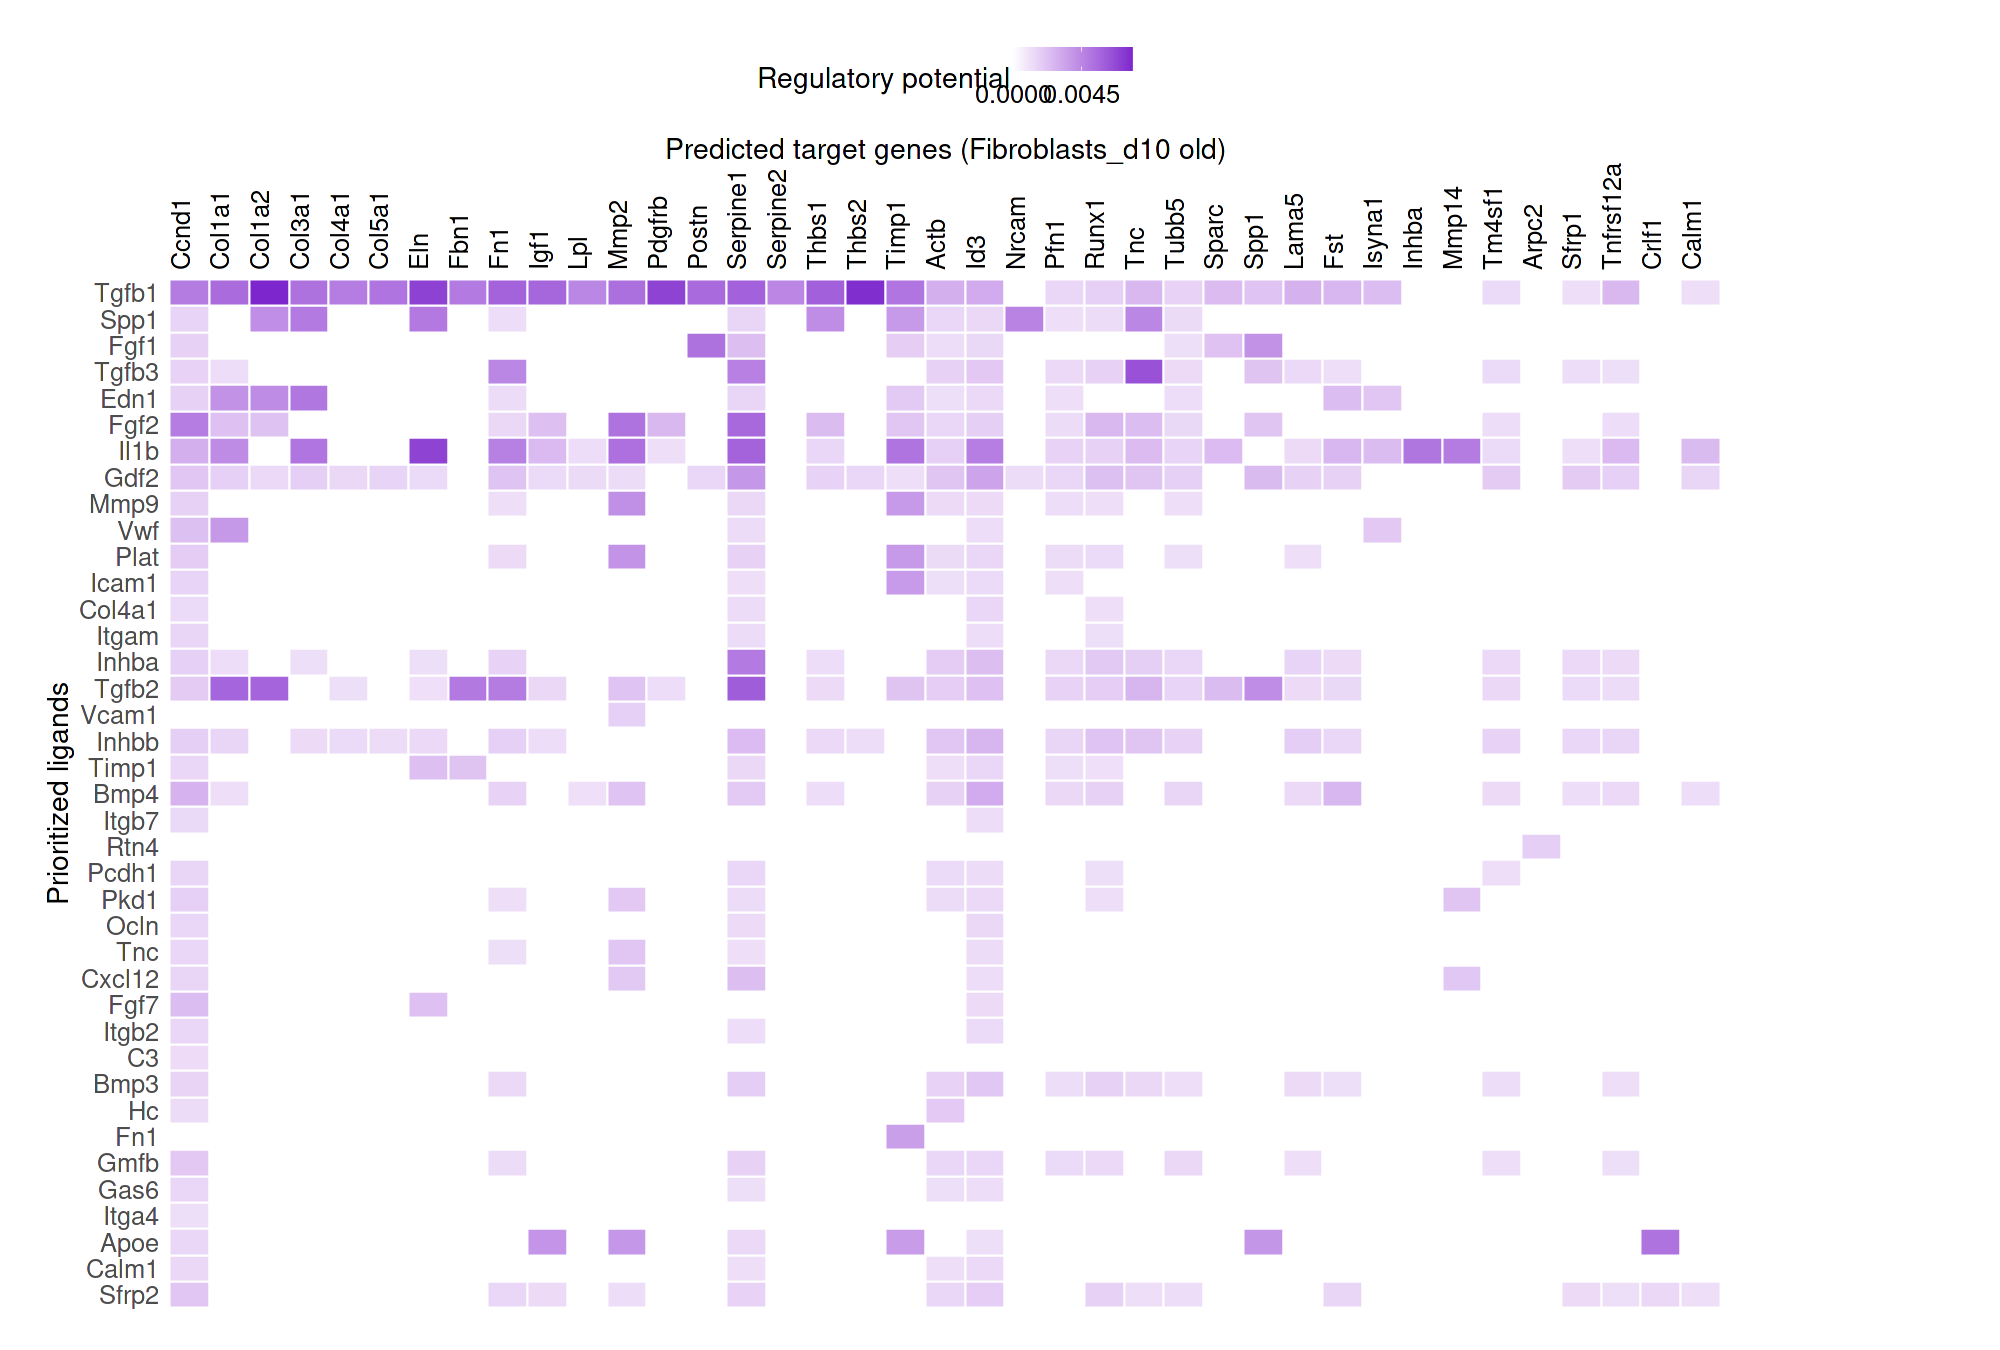

In [107]:
options(repr.plot.width = 20, repr.plot.height = 13.5, repr.plot.res = 100)
folderpath="/home/ramadatta/Analysis/1_Schiller_Lab/for_collaborators/Janine/1_Bleomycin_ageing/Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/"
p1 <- plot_ligand_targets(ligand_act, genes = geneset_oi, top = 40, condition = "old", bottom = 1,
                          receiver_ct = receiver_ct,path=folderpath
                         )
plot(p1)

Warning message:
“Removed 298 rows containing missing values (`geom_point()`).”


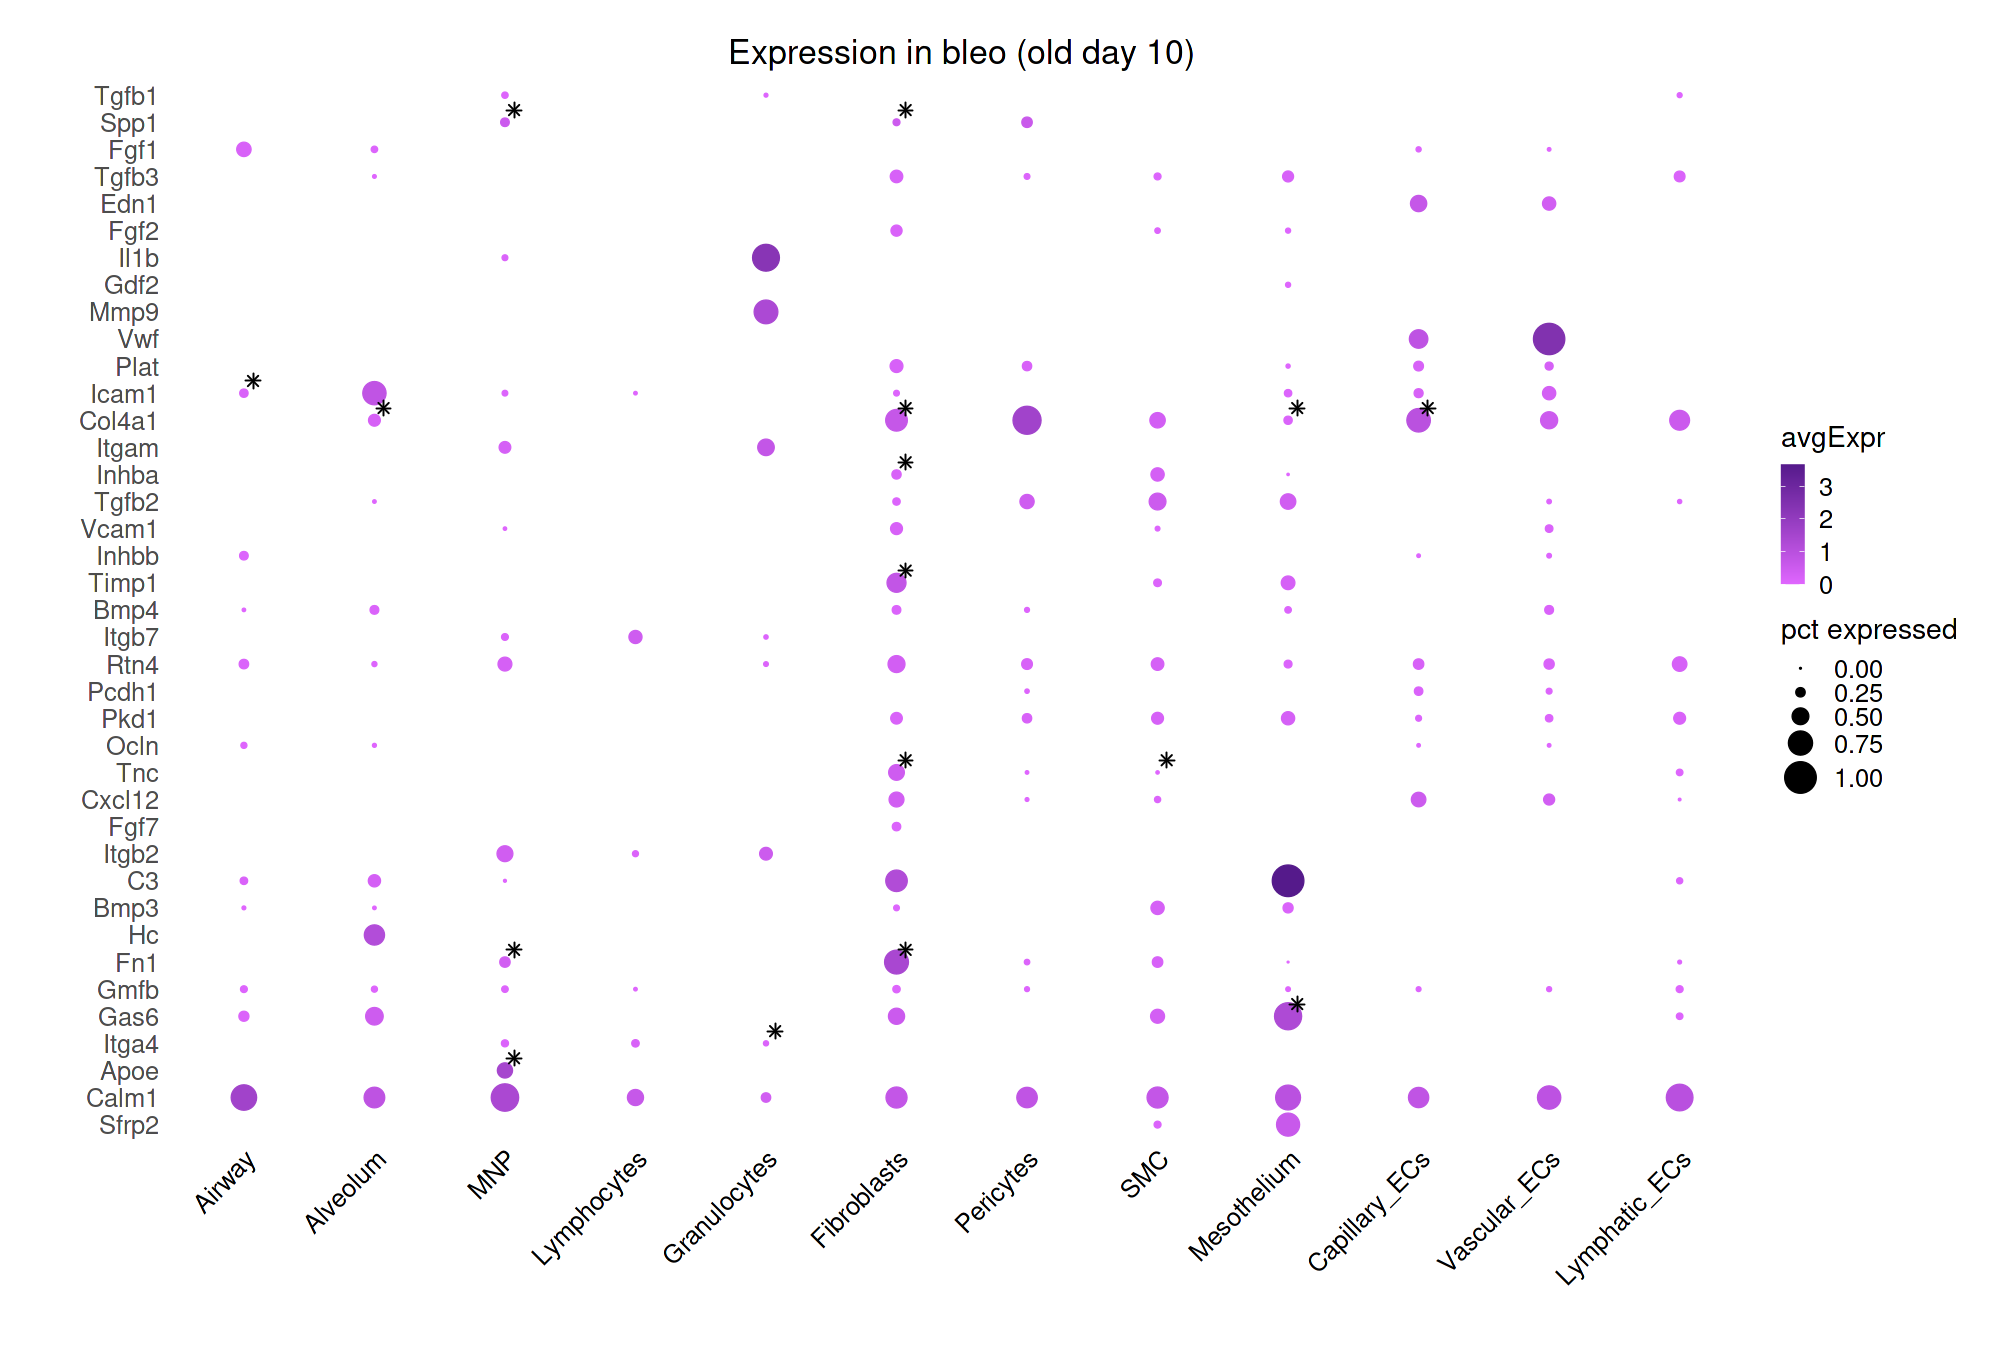

In [108]:
time = "day 10"
p2 <- ligand_dotplot(avg_pct, avg_expr, ligand_act, genes = unique(as.character(p1$data$y)), order = order, star = T,
                     title_add = paste0("(", age, " ", time, ")"), condition = condition, colour = age, col.min = -2, 
                     col.max = 2, scale = TRUE, reg = reg, dot.min = 0.1, dot.scale = 10, top = 40, top_pad = 1)
plot(p2)

### Run and save Tables and plots for all cell types as receiver
#### day 3 old

In [112]:
condition = "bleo"
age = "old"
time = "d3"
path = paste0("Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/", age, "_timeseries/")
reg = paste0("pct\\.|", condition, "_", "|_d[[:alnum:]]+")

avg_expr = master_tab[, grep(paste0("avgExpr_.*_", time), colnames(master_tab))]
avg_pct = master_tab[, grep(paste0("pct.bleo_.*_", time), colnames(master_tab))]
all_upregulated <- get_upregulated_genes_all(time)

In [113]:
str(all_upregulated)

List of 12
 $ Airway_d3       : chr [1:264] "Irf7" "Cd177" "Cxcl17" "Ifitm3" ...
 $ Alveolum_d3     : chr [1:213] "Isg20" "Lgals9" "Ldha" "Lcn2" ...
 $ Capillary_ECs_d3: chr [1:55] "Ace" "mt-Nd2" "mt-Nd1" "mt-Cytb" ...
 $ Fibroblasts_d3  : chr [1:54] "mt-Co1" "Ifitm3" "Ifi27l2a" "Serpina3n" ...
 $ Granulocytes_d3 : chr [1:32] "Lrg1" "Wfdc17" "Ifitm1" "Il1r2" ...
 $ Lymphatic_ECs_d3: chr [1:198] "mt-Co1" "Ly6e" "mt-Nd5" "Gng12" ...
 $ Lymphocytes_d3  : chr [1:35] "Btg1" "mt-Nd2" "mt-Nd1" "mt-Cytb" ...
 $ MNP_d3          : chr [1:71] "AA467197" "Gng5" "Lgals1" "Lgals3bp" ...
 $ Mesothelium_d3  : chr [1:106] "Hoxb2" "Ifitm3" "Fth1" "Slc39a8" ...
 $ Pericytes_d3    : chr [1:32] "mt-Co1" "Ifitm3" "mt-Nd1" "Cdc42" ...
 $ SMC_d3          : chr [1:180] "mt-Co1" "Igfbp7" "mt-Nd5" "Ifitm3" ...
 $ Vascular_ECs_d3 : chr [1:89] "mt-Nd5" "mt-Co1" "Ly6e" "Ly6c1" ...


In [114]:
# Created Plots/NicheNet_meta_output/old_timeseries

for(ct in order){
    receiver_ct = paste0(ct, "_", time)
    print(receiver_ct)
    
    ## Get geneset of interest from pre-created de gene list and save potential ligand tables
    #geneset_oi = get_upregulated_genes_receiver(condition = condition, receiver_ct = receiver_ct)
    geneset_oi = all_upregulated[[receiver_ct]]
    ligand_act <- get_regulatory_potential(avg_pct, avg_pct, reg = reg, geneset_oi, receiver_ct = receiver_ct, 
                                           condition = condition, save = T, path = path,
                                           suffix = paste0("_", age))
}

[1] "Airway_d3"
[1] "Expressed Ligands 212 Expressed Receptors 99"
[1] "Potential Ligands 129"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Airway_d3_reg_potential_old.txt"
[1] "Alveolum_d3"
[1] "Expressed Ligands 212 Expressed Receptors 82"
[1] "Potential Ligands 128"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Alveolum_d3_reg_potential_old.txt"
[1] "MNP_d3"
[1] "Expressed Ligands 212 Expressed Receptors 93"
[1] "Potential Ligands 123"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_MNP_d3_reg_potential_old.txt"
[1] "Lymphocytes_d3"
[1] "Expressed Ligands 212 Expressed Receptors 41"
[1] "Potential Ligands 84"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphocytes_d3_reg_potential_old.txt"
[1] "Granulocytes_d3"
[1] "Expressed Ligands 212 Expressed Recept

### Loop it for the remaining Time Points in old

In [115]:
condition = "bleo"
age = "old"
path = paste0("Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/", age, "_timeseries/")
reg = paste0("pct\\.|", condition, "_", "|_d[[:alnum:]]+")

for(time in c("d3", "d10", "d21", "d28", "d42")){
    print(time)
    avg_expr = master_tab[, grep(paste0("avgExpr_.*_", time), colnames(master_tab))]
    avg_pct = master_tab[, grep(paste0("pct.bleo_.*_", time), colnames(master_tab))]
    all_upregulated <- get_upregulated_genes_all(time)

    for(ct in order){
        receiver_ct = paste0(ct, "_", time)
        print(receiver_ct)

        ## Get geneset of interest from pre-created de gene list and save potential ligand tables
        geneset_oi = all_upregulated[[receiver_ct]]
        ligand_act <- get_regulatory_potential(avg_pct, avg_pct, reg = reg, geneset_oi, receiver_ct = receiver_ct, 
                                               condition = condition, save = T, path = path,
                                               suffix = paste0("_", age))

        ## Do not show plots but save those directly
        plot_regulatory_potential(avg_pct, avg_expr, ligand_act, order = order, reg = reg, receiver_ct = receiver_ct, 
                                  condition = condition, colour = age, star = T, top = 40, top_pad = 1, bottom = 1, 
                                  title_add = paste0("(", age, " ", time, ")"), show = NA, dot.min = 0.05,
                                  path = path, suffix = paste0("_", age), save = T)
    }
}

[1] "d3"
[1] "Airway_d3"
[1] "Expressed Ligands 212 Expressed Receptors 99"
[1] "Potential Ligands 129"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Airway_d3_reg_potential_old.txt"
[1] "number of genes of interest 233"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 307 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Airway_d3_reg_potential_old.pdf"
[1] "Alveolum_d3"
[1] "Expressed Ligands 212 Expressed Receptors 82"
[1] "Potential Ligands 128"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Alveolum_d3_reg_potential_old.txt"
[1] "number of genes of interest 190"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 280 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Alveolum_d3_reg_potential_old.pdf"
[1] "MNP_d3"
[1] "Expressed Ligands 212 Expressed Receptors 93"
[1] "Potential Ligands 123"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_MNP_d3_reg_potential_old.txt"
[1] "number of genes of interest 57"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 266 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_MNP_d3_reg_potential_old.pdf"
[1] "Lymphocytes_d3"
[1] "Expressed Ligands 212 Expressed Receptors 41"
[1] "Potential Ligands 84"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphocytes_d3_reg_potential_old.txt"
[1] "number of genes of interest 25"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 243 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphocytes_d3_reg_potential_old.pdf"
[1] "Granulocytes_d3"
[1] "Expressed Ligands 212 Expressed Receptors 40"
[1] "Potential Ligands 73"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Granulocytes_d3_reg_potential_old.txt"
[1] "number of genes of interest 25"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 161 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Granulocytes_d3_reg_potential_old.pdf"
[1] "Fibroblasts_d3"
[1] "Expressed Ligands 212 Expressed Receptors 110"
[1] "Potential Ligands 157"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Fibroblasts_d3_reg_potential_old.txt"
[1] "number of genes of interest 40"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 255 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Fibroblasts_d3_reg_potential_old.pdf"
[1] "Pericytes_d3"
[1] "Expressed Ligands 212 Expressed Receptors 69"
[1] "Potential Ligands 130"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Pericytes_d3_reg_potential_old.txt"
[1] "number of genes of interest 27"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 49 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Pericytes_d3_reg_potential_old.pdf"
[1] "SMC_d3"
[1] "Expressed Ligands 212 Expressed Receptors 82"
[1] "Potential Ligands 136"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_SMC_d3_reg_potential_old.txt"
[1] "number of genes of interest 163"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 302 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_SMC_d3_reg_potential_old.pdf"
[1] "Mesothelium_d3"
[1] "Expressed Ligands 212 Expressed Receptors 83"
[1] "Potential Ligands 130"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Mesothelium_d3_reg_potential_old.txt"
[1] "number of genes of interest 99"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 202 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Mesothelium_d3_reg_potential_old.pdf"
[1] "Capillary_ECs_d3"
[1] "Expressed Ligands 212 Expressed Receptors 85"
[1] "Potential Ligands 130"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Capillary_ECs_d3_reg_potential_old.txt"
[1] "number of genes of interest 47"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 217 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Capillary_ECs_d3_reg_potential_old.pdf"
[1] "Vascular_ECs_d3"
[1] "Expressed Ligands 212 Expressed Receptors 100"
[1] "Potential Ligands 137"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Vascular_ECs_d3_reg_potential_old.txt"
[1] "number of genes of interest 80"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 189 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Vascular_ECs_d3_reg_potential_old.pdf"
[1] "Lymphatic_ECs_d3"
[1] "Expressed Ligands 212 Expressed Receptors 97"
[1] "Potential Ligands 128"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphatic_ECs_d3_reg_potential_old.txt"
[1] "number of genes of interest 180"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 255 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphatic_ECs_d3_reg_potential_old.pdf"
[1] "d10"
[1] "Airway_d10"
[1] "Expressed Ligands 232 Expressed Receptors 97"
[1] "Potential Ligands 134"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Airway_d10_reg_potential_old.txt"
[1] "number of genes of interest 123"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 299 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Airway_d10_reg_potential_old.pdf"
[1] "Alveolum_d10"
[1] "Expressed Ligands 232 Expressed Receptors 91"
[1] "Potential Ligands 143"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Alveolum_d10_reg_potential_old.txt"
[1] "number of genes of interest 414"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 272 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Alveolum_d10_reg_potential_old.pdf"
[1] "MNP_d10"
[1] "Expressed Ligands 232 Expressed Receptors 106"
[1] "Potential Ligands 144"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_MNP_d10_reg_potential_old.txt"
[1] "number of genes of interest 106"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 295 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_MNP_d10_reg_potential_old.pdf"
[1] "Lymphocytes_d10"
[1] "Expressed Ligands 232 Expressed Receptors 48"
[1] "Potential Ligands 104"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphocytes_d10_reg_potential_old.txt"
[1] "number of genes of interest 82"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 271 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphocytes_d10_reg_potential_old.pdf"
[1] "Granulocytes_d10"
[1] "Expressed Ligands 232 Expressed Receptors 45"
[1] "Potential Ligands 92"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Granulocytes_d10_reg_potential_old.txt"
[1] "number of genes of interest 55"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 163 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Granulocytes_d10_reg_potential_old.pdf"
[1] "Fibroblasts_d10"
[1] "Expressed Ligands 232 Expressed Receptors 127"
[1] "Potential Ligands 182"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Fibroblasts_d10_reg_potential_old.txt"
[1] "number of genes of interest 95"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 298 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Fibroblasts_d10_reg_potential_old.pdf"
[1] "Pericytes_d10"
[1] "Expressed Ligands 232 Expressed Receptors 86"
[1] "Potential Ligands 154"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Pericytes_d10_reg_potential_old.txt"
[1] "number of genes of interest 75"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 224 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Pericytes_d10_reg_potential_old.pdf"
[1] "SMC_d10"
[1] "Expressed Ligands 232 Expressed Receptors 91"
[1] "Potential Ligands 151"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_SMC_d10_reg_potential_old.txt"
[1] "number of genes of interest 143"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 215 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_SMC_d10_reg_potential_old.pdf"
[1] "Mesothelium_d10"
[1] "Expressed Ligands 232 Expressed Receptors 85"
[1] "Potential Ligands 142"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Mesothelium_d10_reg_potential_old.txt"
[1] "number of genes of interest 81"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 313 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Mesothelium_d10_reg_potential_old.pdf"
[1] "Capillary_ECs_d10"
[1] "Expressed Ligands 232 Expressed Receptors 101"
[1] "Potential Ligands 155"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Capillary_ECs_d10_reg_potential_old.txt"
[1] "number of genes of interest 178"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 227 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Capillary_ECs_d10_reg_potential_old.pdf"
[1] "Vascular_ECs_d10"
[1] "Expressed Ligands 232 Expressed Receptors 120"
[1] "Potential Ligands 159"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Vascular_ECs_d10_reg_potential_old.txt"
[1] "number of genes of interest 202"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 247 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Vascular_ECs_d10_reg_potential_old.pdf"
[1] "Lymphatic_ECs_d10"
[1] "Expressed Ligands 232 Expressed Receptors 96"
[1] "Potential Ligands 137"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphatic_ECs_d10_reg_potential_old.txt"
[1] "number of genes of interest 117"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 242 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphatic_ECs_d10_reg_potential_old.pdf"
[1] "d21"
[1] "Airway_d21"
[1] "Expressed Ligands 213 Expressed Receptors 80"
[1] "Potential Ligands 116"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Airway_d21_reg_potential_old.txt"
[1] "number of genes of interest 379"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 301 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Airway_d21_reg_potential_old.pdf"
[1] "Alveolum_d21"
[1] "Expressed Ligands 213 Expressed Receptors 81"
[1] "Potential Ligands 132"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Alveolum_d21_reg_potential_old.txt"
[1] "number of genes of interest 660"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 311 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Alveolum_d21_reg_potential_old.pdf"
[1] "MNP_d21"
[1] "Expressed Ligands 213 Expressed Receptors 76"
[1] "Potential Ligands 121"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_MNP_d21_reg_potential_old.txt"
[1] "number of genes of interest 167"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 259 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_MNP_d21_reg_potential_old.pdf"
[1] "Lymphocytes_d21"
[1] "Expressed Ligands 213 Expressed Receptors 32"
[1] "Potential Ligands 70"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphocytes_d21_reg_potential_old.txt"
[1] "number of genes of interest 3"


ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `x = factor(x, levels = colnames(matrix), ordered = TRUE)`.
[1mCaused by error in `factor()`:[22m
[33m![39m object 'x' not found


In [157]:
## Some issue with bleo_Lymphocytes_d21_reg_potential_old.txt, skipping this and running the rest
head(ligand_act)

test_ligand,auroc,aupr,aupr_corrected,pearson,rank,expressed_in,upregulated_in
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Lama2,0.6573486,0.042496424,0.0386989554,0.15881589,1,Fibroblasts,
App,0.4379500,0.020502915,0.0167054466,0.04885717,2,"Airway, Alveolum, Capillary_ECs, Fibroblasts, Granulocytes, Lymphatic_ECs, MNP, Mesothelium, Pericytes, SMC, Vascular_ECs",
Igf1,0.5705210,0.006867477,0.0030700086,0.04626062,3,"Fibroblasts, MNP","Fibroblasts, MNP"
Clstn1,0.4239729,0.003061263,-0.0007362056,-0.01590800,4,"Airway, Alveolum, Capillary_ECs, Fibroblasts, Lymphatic_ECs, Mesothelium, Pericytes, SMC, Vascular_ECs",
Ptprm,0.4409149,0.003351086,-0.0004463825,-0.02163268,5,"Capillary_ECs, Lymphatic_ECs, Vascular_ECs",
Calr,0.2075392,0.002213403,-0.0015840657,-0.02216744,6,"Airway, Alveolum, Capillary_ECs, Fibroblasts, Lymphatic_ECs, Lymphocytes, MNP, Mesothelium, Pericytes, SMC, Vascular_ECs",


In [159]:
condition = "bleo"
age = "old"
path = paste0("Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/", age, "_timeseries/")
reg = paste0("pct\\.|", condition, "_", "|_d[[:alnum:]]+")

for(time in c("d21", "d28", "d42")){
    avg_expr = master_tab[, grep(paste0("avgExpr_.*_", time), colnames(master_tab))]
    avg_pct = master_tab[, grep(paste0("pct.bleo_.*_", time), colnames(master_tab))]
    all_upregulated <- get_upregulated_genes_all(time)

    for(ct in order){
        if(time == "d21" & ct %in% c('Airway_epithelium', 'Alveolar_epithelium', 'MNP', "Lymphocytes")){
            next
        }
        receiver_ct = paste0(ct, "_", time)
        print(receiver_ct)

        ## Get geneset of interest from pre-created de gene list and save potential ligand tables
        #geneset_oi = get_upregulated_genes_receiver(condition = condition, receiver_ct = receiver_ct)
        geneset_oi = all_upregulated[[receiver_ct]]
        ligand_act <- get_regulatory_potential(avg_pct, avg_pct, reg = reg, geneset_oi, receiver_ct = receiver_ct, 
                                               condition = condition, save = T, path = path,
                                               suffix = paste0("_", age))

        ## Do not show plots but save those directly
        plot_regulatory_potential(avg_pct, avg_expr, ligand_act, order = order, reg = reg, receiver_ct = receiver_ct, 
                                  condition = condition, colour = age, star = T, top = 40, top_pad = 1, bottom = 1, 
                                  title_add = paste0("(", age, " ", time, ")"), show = NA, dot.min = 0.05,
                                  path = path, suffix = paste0("_", age), save = T)
    }
}

[1] "Airway_d21"
[1] "Expressed Ligands 213 Expressed Receptors 80"
[1] "Potential Ligands 116"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Airway_d21_reg_potential_old.txt"
[1] "number of genes of interest 379"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 301 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Airway_d21_reg_potential_old.pdf"
[1] "Alveolum_d21"
[1] "Expressed Ligands 213 Expressed Receptors 81"
[1] "Potential Ligands 132"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Alveolum_d21_reg_potential_old.txt"
[1] "number of genes of interest 660"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 311 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Alveolum_d21_reg_potential_old.pdf"
[1] "Granulocytes_d21"
[1] "Expressed Ligands 213 Expressed Receptors 34"
[1] "Potential Ligands 84"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Granulocytes_d21_reg_potential_old.txt"
[1] "number of genes of interest 15"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 144 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Granulocytes_d21_reg_potential_old.pdf"
[1] "Fibroblasts_d21"
[1] "Expressed Ligands 213 Expressed Receptors 116"
[1] "Potential Ligands 166"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Fibroblasts_d21_reg_potential_old.txt"
[1] "number of genes of interest 239"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 306 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Fibroblasts_d21_reg_potential_old.pdf"
[1] "Pericytes_d21"
[1] "Expressed Ligands 213 Expressed Receptors 64"
[1] "Potential Ligands 134"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Pericytes_d21_reg_potential_old.txt"
[1] "number of genes of interest 117"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 262 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Pericytes_d21_reg_potential_old.pdf"
[1] "SMC_d21"
[1] "Expressed Ligands 213 Expressed Receptors 87"
[1] "Potential Ligands 142"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_SMC_d21_reg_potential_old.txt"
[1] "number of genes of interest 119"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 268 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_SMC_d21_reg_potential_old.pdf"
[1] "Mesothelium_d21"
[1] "Expressed Ligands 213 Expressed Receptors 71"
[1] "Potential Ligands 121"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Mesothelium_d21_reg_potential_old.txt"
[1] "number of genes of interest 183"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 225 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Mesothelium_d21_reg_potential_old.pdf"
[1] "Capillary_ECs_d21"
[1] "Expressed Ligands 213 Expressed Receptors 82"
[1] "Potential Ligands 133"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Capillary_ECs_d21_reg_potential_old.txt"
[1] "number of genes of interest 264"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 254 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Capillary_ECs_d21_reg_potential_old.pdf"
[1] "Vascular_ECs_d21"
[1] "Expressed Ligands 213 Expressed Receptors 99"
[1] "Potential Ligands 139"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Vascular_ECs_d21_reg_potential_old.txt"
[1] "number of genes of interest 247"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 277 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Vascular_ECs_d21_reg_potential_old.pdf"
[1] "Lymphatic_ECs_d21"
[1] "Expressed Ligands 213 Expressed Receptors 79"
[1] "Potential Ligands 123"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphatic_ECs_d21_reg_potential_old.txt"
[1] "number of genes of interest 336"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 239 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphatic_ECs_d21_reg_potential_old.pdf"
[1] "Airway_d28"
[1] "Expressed Ligands 227 Expressed Receptors 89"
[1] "Potential Ligands 132"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Airway_d28_reg_potential_old.txt"
[1] "number of genes of interest 131"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 253 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Airway_d28_reg_potential_old.pdf"
[1] "Alveolum_d28"
[1] "Expressed Ligands 227 Expressed Receptors 82"
[1] "Potential Ligands 143"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Alveolum_d28_reg_potential_old.txt"
[1] "number of genes of interest 132"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 272 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Alveolum_d28_reg_potential_old.pdf"
[1] "MNP_d28"
[1] "Expressed Ligands 227 Expressed Receptors 99"
[1] "Potential Ligands 137"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_MNP_d28_reg_potential_old.txt"
[1] "number of genes of interest 83"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 237 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_MNP_d28_reg_potential_old.pdf"
[1] "Lymphocytes_d28"
[1] "Expressed Ligands 227 Expressed Receptors 39"
[1] "Potential Ligands 95"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphocytes_d28_reg_potential_old.txt"
[1] "number of genes of interest 6"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 175 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphocytes_d28_reg_potential_old.pdf"
[1] "Granulocytes_d28"
[1] "Expressed Ligands 227 Expressed Receptors 40"
[1] "Potential Ligands 88"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Granulocytes_d28_reg_potential_old.txt"
[1] "number of genes of interest 44"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 177 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Granulocytes_d28_reg_potential_old.pdf"
[1] "Fibroblasts_d28"
[1] "Expressed Ligands 227 Expressed Receptors 129"
[1] "Potential Ligands 174"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Fibroblasts_d28_reg_potential_old.txt"
[1] "number of genes of interest 80"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 289 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Fibroblasts_d28_reg_potential_old.pdf"
[1] "Pericytes_d28"
[1] "Expressed Ligands 227 Expressed Receptors 86"
[1] "Potential Ligands 155"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Pericytes_d28_reg_potential_old.txt"
[1] "number of genes of interest 72"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 206 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Pericytes_d28_reg_potential_old.pdf"
[1] "SMC_d28"
[1] "Expressed Ligands 227 Expressed Receptors 88"
[1] "Potential Ligands 152"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_SMC_d28_reg_potential_old.txt"
[1] "number of genes of interest 129"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 262 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_SMC_d28_reg_potential_old.pdf"
[1] "Mesothelium_d28"
[1] "Expressed Ligands 227 Expressed Receptors 82"
[1] "Potential Ligands 142"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Mesothelium_d28_reg_potential_old.txt"
[1] "number of genes of interest 53"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 155 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Mesothelium_d28_reg_potential_old.pdf"
[1] "Capillary_ECs_d28"
[1] "Expressed Ligands 227 Expressed Receptors 99"
[1] "Potential Ligands 150"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Capillary_ECs_d28_reg_potential_old.txt"
[1] "number of genes of interest 166"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 227 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Capillary_ECs_d28_reg_potential_old.pdf"
[1] "Vascular_ECs_d28"
[1] "Expressed Ligands 227 Expressed Receptors 113"
[1] "Potential Ligands 156"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Vascular_ECs_d28_reg_potential_old.txt"
[1] "number of genes of interest 75"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 271 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Vascular_ECs_d28_reg_potential_old.pdf"
[1] "Lymphatic_ECs_d28"
[1] "Expressed Ligands 227 Expressed Receptors 87"
[1] "Potential Ligands 134"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphatic_ECs_d28_reg_potential_old.txt"
[1] "number of genes of interest 213"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 206 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphatic_ECs_d28_reg_potential_old.pdf"
[1] "Airway_d42"
[1] "Expressed Ligands 209 Expressed Receptors 78"
[1] "Potential Ligands 115"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Airway_d42_reg_potential_old.txt"
[1] "number of genes of interest 136"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 219 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Airway_d42_reg_potential_old.pdf"
[1] "Alveolum_d42"
[1] "Expressed Ligands 209 Expressed Receptors 66"
[1] "Potential Ligands 114"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Alveolum_d42_reg_potential_old.txt"
[1] "number of genes of interest 132"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 267 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Alveolum_d42_reg_potential_old.pdf"
[1] "MNP_d42"
[1] "Expressed Ligands 209 Expressed Receptors 73"
[1] "Potential Ligands 123"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_MNP_d42_reg_potential_old.txt"
[1] "number of genes of interest 128"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 167 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_MNP_d42_reg_potential_old.pdf"
[1] "Lymphocytes_d42"
[1] "Expressed Ligands 209 Expressed Receptors 33"
[1] "Potential Ligands 88"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphocytes_d42_reg_potential_old.txt"
[1] "number of genes of interest 53"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 94 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphocytes_d42_reg_potential_old.pdf"
[1] "Granulocytes_d42"
[1] "Expressed Ligands 209 Expressed Receptors 39"
[1] "Potential Ligands 81"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Granulocytes_d42_reg_potential_old.txt"
[1] "number of genes of interest 84"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 186 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Granulocytes_d42_reg_potential_old.pdf"
[1] "Fibroblasts_d42"
[1] "Expressed Ligands 209 Expressed Receptors 106"
[1] "Potential Ligands 157"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Fibroblasts_d42_reg_potential_old.txt"
[1] "number of genes of interest 96"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 296 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Fibroblasts_d42_reg_potential_old.pdf"
[1] "Pericytes_d42"
[1] "Expressed Ligands 209 Expressed Receptors 64"
[1] "Potential Ligands 127"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Pericytes_d42_reg_potential_old.txt"
[1] "number of genes of interest 49"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 217 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Pericytes_d42_reg_potential_old.pdf"
[1] "SMC_d42"
[1] "Expressed Ligands 209 Expressed Receptors 58"
[1] "Potential Ligands 122"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_SMC_d42_reg_potential_old.txt"
[1] "number of genes of interest 92"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 121 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_SMC_d42_reg_potential_old.pdf"
[1] "Mesothelium_d42"
[1] "Expressed Ligands 209 Expressed Receptors 76"
[1] "Potential Ligands 141"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Mesothelium_d42_reg_potential_old.txt"
[1] "number of genes of interest 55"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Mesothelium_d42_reg_potential_old.pdf"
[1] "Capillary_ECs_d42"
[1] "Expressed Ligands 209 Expressed Receptors 76"
[1] "Potential Ligands 127"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Capillary_ECs_d42_reg_potential_old.txt"
[1] "number of genes of interest 232"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 184 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Capillary_ECs_d42_reg_potential_old.pdf"
[1] "Vascular_ECs_d42"
[1] "Expressed Ligands 209 Expressed Receptors 98"
[1] "Potential Ligands 136"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Vascular_ECs_d42_reg_potential_old.txt"
[1] "number of genes of interest 62"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 173 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Vascular_ECs_d42_reg_potential_old.pdf"
[1] "Lymphatic_ECs_d42"
[1] "Expressed Ligands 209 Expressed Receptors 74"
[1] "Potential Ligands 119"
[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphatic_ECs_d42_reg_potential_old.txt"
[1] "number of genes of interest 208"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 156 rows containing missing values (`geom_point()`).”


[1] "Saving to Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/old_timeseries/bleo_Lymphatic_ECs_d42_reg_potential_old.pdf"


# Young

### Generate adjacency matrices for all time points in young mice

In [160]:
path ="Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/"

generate_rec_lig_matrix <- function(order, age = "young", time = "d10", thresh = 0.06, do_return = NA, save = NA){
    
    ## Make two matrices, and add 1 for each listed cell type per ligand
    mat = data.frame(matrix(0, length(ct_order), length(ct_order), dimnames = list(ct_order, ct_order)),
                     stringsAsFactors = F, check.names = F)
    mat_up = data.frame(matrix(0, length(ct_order), length(ct_order), dimnames = list(ct_order, ct_order)),
                        stringsAsFactors = F, check.names = F)
    
    for(receiver_ct in order){
        file <- paste0(age, "_timeseries/bleo_", receiver_ct, "_", time, "_reg_potential_", age, ".txt")
        
        ## Added test to whether file is existent or output was empty for particular cell type
        if(file.exists(paste0(path, file))){
            tab <- read.delim(paste0(path, file), sep = "\t", stringsAsFactors = F)
            print(paste("Reading", file))

            tab <- tab[tab$pearson > thresh,]
            mat[, receiver_ct] <- sapply(rownames(mat), function(x){sum(str_count(tab$expressed_in, x))})
            mat_up[, receiver_ct] <- sapply(rownames(mat_up), function(x){sum(str_count(tab$upregulated_in, x))})
        }
    }
    matrices <- list(expressed = mat, upregulated = mat_up)
    
    if(!is.na(save)){
        for(version in c("expressed", "upregulated")){
            out_file <- paste0(age, "_timeseries/adjacency_matrix_", version, "_", time, "_", age, ".txt")
            print(paste("Saving to", out_file))
            write.table(matrices[[version]], paste0(path, out_file), quote = F, sep = "\t")
        }
    }
    if(!is.na(do_return)){
        return(matrices)
    }
}

In [161]:
age = "young"

for(time in c("d3", "d10", "d21", "d28", "d42")){
    matrices <- generate_rec_lig_matrix(ct_order, age = age, time = time, thresh = 0.06, do_return = T, save = T)
    print("")
}

[1] "Reading young_timeseries/bleo_Airway_d3_reg_potential_young.txt"
[1] "Reading young_timeseries/bleo_Alveolum_d3_reg_potential_young.txt"
[1] "Reading young_timeseries/bleo_MNP_d3_reg_potential_young.txt"
[1] "Reading young_timeseries/bleo_Lymphocytes_d3_reg_potential_young.txt"
[1] "Reading young_timeseries/bleo_Granulocytes_d3_reg_potential_young.txt"
[1] "Reading young_timeseries/bleo_Fibroblasts_d3_reg_potential_young.txt"
[1] "Reading young_timeseries/bleo_Pericytes_d3_reg_potential_young.txt"
[1] "Reading young_timeseries/bleo_SMC_d3_reg_potential_young.txt"
[1] "Reading young_timeseries/bleo_Mesothelium_d3_reg_potential_young.txt"
[1] "Reading young_timeseries/bleo_Capillary_ECs_d3_reg_potential_young.txt"
[1] "Reading young_timeseries/bleo_Vascular_ECs_d3_reg_potential_young.txt"
[1] "Reading young_timeseries/bleo_Lymphatic_ECs_d3_reg_potential_young.txt"
[1] "Saving to young_timeseries/adjacency_matrix_expressed_d3_young.txt"
[1] "Saving to young_timeseries/adjacency_matri

# Old

### Generate adjacency matrices for all time points in old mice

In [168]:
path ="Bleomycin_datta_output_scripts/4_Whole_Pipeline/NicheNet_meta_output/"

generate_rec_lig_matrix <- function(order, age = "old", time = "d10", thresh = 0.06, do_return = NA, save = NA){
    
    ## Make two matrices, and add 1 for each listed cell type per ligand
    mat = data.frame(matrix(0, length(ct_order), length(ct_order), dimnames = list(ct_order, ct_order)),
                     stringsAsFactors = F, check.names = F)
    mat_up = data.frame(matrix(0, length(ct_order), length(ct_order), dimnames = list(ct_order, ct_order)),
                        stringsAsFactors = F, check.names = F)
    
    for(receiver_ct in order){
        file <- paste0(age, "_timeseries/bleo_", receiver_ct, "_", time, "_reg_potential_", age, ".txt")
        
        ## Added test to whether file is existent or output was empty for particular cell type
        if(file.exists(paste0(path, file))){
            tab <- read.delim(paste0(path, file), sep = "\t", stringsAsFactors = F)
            print(paste("Reading", file))

            tab <- tab[tab$pearson > thresh,]
            mat[, receiver_ct] <- sapply(rownames(mat), function(x){sum(str_count(tab$expressed_in, x))})
            mat_up[, receiver_ct] <- sapply(rownames(mat_up), function(x){sum(str_count(tab$upregulated_in, x))})
        }
    }
    matrices <- list(expressed = mat, upregulated = mat_up)
    
    if(!is.na(save)){
        for(version in c("expressed", "upregulated")){
            out_file <- paste0(age, "_timeseries/adjacency_matrix_", version, "_", time, "_", age, ".txt")
            print(paste("Saving to", out_file))
            write.table(matrices[[version]], paste0(path, out_file), quote = F, sep = "\t")
        }
    }
    if(!is.na(do_return)){
        return(matrices)
    }
}

In [169]:
age = "old"

for(time in c("d3", "d10", "d21", "d28", "d42")){
    matrices <- generate_rec_lig_matrix(ct_order, age = age, time = time, thresh = 0.06, do_return = T, save = T)
    print("")
}

[1] "Reading old_timeseries/bleo_Airway_d3_reg_potential_old.txt"
[1] "Reading old_timeseries/bleo_Alveolum_d3_reg_potential_old.txt"
[1] "Reading old_timeseries/bleo_MNP_d3_reg_potential_old.txt"
[1] "Reading old_timeseries/bleo_Lymphocytes_d3_reg_potential_old.txt"
[1] "Reading old_timeseries/bleo_Granulocytes_d3_reg_potential_old.txt"
[1] "Reading old_timeseries/bleo_Fibroblasts_d3_reg_potential_old.txt"
[1] "Reading old_timeseries/bleo_Pericytes_d3_reg_potential_old.txt"
[1] "Reading old_timeseries/bleo_SMC_d3_reg_potential_old.txt"
[1] "Reading old_timeseries/bleo_Mesothelium_d3_reg_potential_old.txt"
[1] "Reading old_timeseries/bleo_Capillary_ECs_d3_reg_potential_old.txt"
[1] "Reading old_timeseries/bleo_Vascular_ECs_d3_reg_potential_old.txt"
[1] "Reading old_timeseries/bleo_Lymphatic_ECs_d3_reg_potential_old.txt"
[1] "Saving to old_timeseries/adjacency_matrix_expressed_d3_old.txt"
[1] "Saving to old_timeseries/adjacency_matrix_upregulated_d3_old.txt"
[1] ""
[1] "Reading old_time